# Plotting II

In [4]:
from utils import (
                BaseForecaster, 
                ResidualForecaster,
                TimeSeriesPreprocessor,
                crps,
                HistoricalForecaster
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
import numpy as np
import CRPS.CRPS as forecastscore
from darts.metrics import rmse
import matplotlib as mpl

targets = pd.read_csv("targets.csv.gz")

In [58]:
targets = pd.read_csv("targets.csv.gz")

# For the training set
data_preprocessor = TimeSeriesPreprocessor(
    validation_split_date='2022-07-19',
    load_dir_name='preprocessed_train/',
)

_ = [data_preprocessor.preprocess_data(site) for site in ['BARC']]

data_preprocessor.save()

In [ ]:
def month_doy_range(year, month):
    # Get the first day of the month
    first_day = datetime(year, month, 1)

    # Calculating the last day of the month
    if month == 12:
        last_day = datetime(year + 1, 1, 1) - timedelta(days=1)
    else:
        last_day = datetime(year, month + 1, 1) - timedelta(days=1)

    # Finding the day of year for the first and last day
    doy_first_day = first_day.timetuple().tm_yday
    doy_last_day = last_day.timetuple().tm_yday

    return doy_first_day, doy_last_day

def season_doy_range(year, month, day):
    # Given date
    given_date = datetime(year, month, day)

    # Arbitrarily definine the start and end dates for each season
    spring_start = datetime(year, 3, 1)
    summer_start = datetime(year, 6, 1)
    fall_start = datetime(year, 9, 1)
    winter_start = datetime(year, 12, 1)

    # Determine the season based on the given date
    if given_date < spring_start or given_date >= datetime(year + 1, 3, 1):
        season = "winter"
        start_date = winter_start
        end_date = datetime(year + 1, 2, 28)  # Assuming non-leap year
    elif given_date < summer_start:
        season = "spring"
        start_date = spring_start
        end_date = summer_start - timedelta(days=1)
    elif given_date < fall_start:
        season = "summer"
        start_date = summer_start
        end_date = fall_start - timedelta(days=1)
    elif given_date < winter_start:
        season = "fall"
        start_date = fall_start
        end_date = winter_start - timedelta(days=1)

    # Calculate the DOY range for the determined season
    doy_start = start_date.timetuple().tm_yday
    doy_end = end_date.timetuple().tm_yday

    return doy_start, doy_end

class TimeSeriesPreprocessor():
    def __init__(self,
                 input_csv_name = "targets.csv.gz",
                 load_dir_name: Optional[str] = "preprocessed_timeseries/",
                 datetime_column_name: Optional[str] = "datetime",
                 validation_split_date: Optional[str] = "2023-03-09",
                 filter_kw_args: Optional[dict] = {"alpha_0": 0.001,
                                                   "n_restarts_0": 100,
                                                   "num_samples": 500,},
                 ):
        self.input_csv_name = input_csv_name
        self.load_dir_name = load_dir_name
        self.datetime_column_name = datetime_column_name
        self.filter_kw_args = filter_kw_args
        self.sites_dict = {}

        self.year = int(validation_split_date[:4])
        month = int(validation_split_date[5:7])
        day = int(validation_split_date[8:])
        self.split_date = pd.Timestamp(year=self.year, month=month, day=day)
        self.df = pd.read_csv(self.input_csv_name)
        self.df['datetime'] = pd.to_datetime(self.df.datetime)
        self.df = self.df[self.df.datetime <= self.split_date]
    
    def make_stitched_series(self, var):
        """
        Returns a time series where the gaps have been filled in via
        Gaussian Process Filters
        """
        kernel = RBF()
        
        gpf_missing = GaussianProcessFilter(kernel=kernel, 
                        alpha=self.filter_kw_args["alpha_0"], 
                        n_restarts_optimizer=self.filter_kw_args["n_restarts_0"])
        
        stitched_series = {}
    
        # Filtering the TimeSeries
        try:
            filtered = gpf_missing.filter(self.var_tseries_dict[var], 
                                          num_samples=self.filter_kw_args["num_samples"])
        except:
            return None
    
        # If there is a gap over 7 indices, use big gap filter
        gap_series = self.var_tseries_dict[var].gaps()
        stitched_df = filtered.pd_dataframe(suppress_warnings=True)
        
        # Ignoring runtime warnings in this function only
        # This is because I allow means to be found of empty arrays,
        # yielding NaNs, which is certainly not elegant
        warnings.filterwarnings("ignore", category=RuntimeWarning)

        # For these big gaps, I replace with samples centered on historical mean and std
        for index, row in gap_series.iterrows():
            if row["gap_size"] > 7:
                for date in pd.date_range(row["gap_start"], row["gap_end"]):
                    # Finding the mean and std from the doy dictionary
                    # and avoiding leap year errors
                    try:
                        mean, std = self.doy_dict[var].loc[min(date.dayofyear, 365)]
                        # If there is an issue, use the median daily historical data
                        # over that month
                        if np.isnan(mean):
                            month_range = month_doy_range(date.year, date.month)
                            mean = (
                                self.doy_dict[var]
                                .loc[month_range[0]:month_range[1]]['mean']
                                .median()
                            )
                            if np.isnan(mean):
                                # And if this is still NaN, aggregate over the season
                                season_range = season_doy_range(
                                    date.year, date.month, date.day
                                )
                                mean = (
                                    self.doy_dict[var]
                                    .loc[season_range[0]:season_range[1]]['mean']
                                    .median()
                                )
                        if np.isnan(std):
                            # Not exactly sure why but filtering looks way better
                            # if I use the std over a season; this ends up not mattering
                            # as the model only uses the median.
                            season_range = season_doy_range(
                                    date.year, date.month, date.day
                            )
                            std = (
                                self.doy_dict[var]
                                .loc[season_range[0]:season_range[1]]['std']
                                .median()
                            )
                    except:
                        # If there is an issue, use the monthly mean and std
                        month_range = month_doy_range(date.year, date.month)
                        mean = (
                            self.doy_dict[var]
                            .loc[month_range[0]:month_range[1]]['mean']
                            .median()
                        )
                        std = (
                            self.doy_dict[var]
                            .loc[month_range[0]:month_range[1]]['std']
                            .median()
                        )
                    stitched_df.loc[date] = np.random.normal(mean, std, size=(500,))
        
        stitched_series = TimeSeries.from_times_and_values(
                              stitched_df.index, 
                              stitched_df.values.reshape(
                                  len(stitched_df), 
                                  1, 
                                  -1,
                              )
        )
        
        return stitched_series

    def preprocess_data(self, site):
        """
        Performs gap filling and processing of data into format that
        Darts models will accept
        """
        self.sites_dict_null = {}
        # Preparing a dataframe
        site_df = self.df.loc[self.df.site_id == site]
        times = pd.to_datetime(site_df[self.datetime_column_name])
        times = pd.DatetimeIndex(times)

        # Dealing with no data being included up until splitting date
        if times[-1] != self.split_date:
            new_row = pd.DataFrame({'datetime': [self.split_date], 
                                    'site_id': [site], 
                                    'chla': [np.nan], 
                                    'oxygen': [np.nan], 
                                    'temperature': [np.nan], 
                                    'air_tmp': [np.nan]})
            site_df = pd.concat([site_df, new_row], 
                                ignore_index=True).reset_index(drop=True)
            times = pd.to_datetime(site_df[self.datetime_column_name])
            times = pd.DatetimeIndex(times)

        self.make_doy_dict(site_df)
        variable_list = ["chla", "oxygen", "temperature", "air_tmp"]
        self.var_tseries_dict = {var: TimeSeries.from_times_and_values(times, 
                                                                 site_df[[var]], 
                                                                 fill_missing_dates=True,
                                                                 freq="D") 
                                                        for var in variable_list}

        stitched_series_dict = {var: self.make_stitched_series(var)
                                                    for var in variable_list}

        # Deleting keys with none values
        keys_to_remove = [key for key, value in stitched_series_dict.items() if value == None]
        for key in keys_to_remove:
            del stitched_series_dict[key]

        # Checking that last date of stitched series is the validation split date
        for var in stitched_series_dict.keys():
            last_date = stitched_series_dict[var].time_index[-1]
            if last_date != self.split_date:
                raise Exception("Error with dates between" +\
                                " split date and the last observation in" +\
                                " the stitched series.")

        self.sites_dict[site] = stitched_series_dict
        self.sites_dict_null[site] = keys_to_remove

    def make_doy_dict(self, site_df):
        tidy_df = pd.melt(site_df, 
                          id_vars=['datetime', 'site_id'], 
                          var_name='variable', 
                          value_name='observation')
        # Now finding the mean and std according to day of the year
        tidy_df["day_of_year"] = tidy_df["datetime"].dt.dayofyear
        self.doy_dict = {}
        # Now loop over variables to make a dictionary of doy_df's
        for variable in ["chla", "oxygen", "temperature", "air_tmp"]:
            tidy_variable_df = tidy_df.loc[tidy_df.variable == variable]
            doy_df = tidy_variable_df.groupby(['day_of_year'])['observation'].agg(['mean', 'std'])
            self.doy_dict[variable] = doy_df
    
    def save(self):
        # Check if there's a dir already
        if not os.path.exists(self.load_dir_name):
            os.makedirs(self.load_dir_name)

        # Saving each TimeSeries
        for site in self.sites_dict.keys():
            for variable in self.sites_dict[site]:
                self.sites_dict[site][variable].pd_dataframe(suppress_warnings=True)\
                    .to_csv(f"{self.load_dir_name}{site}-{variable}.csv")

    def load(self, site):
        # Need to check what are the possible variables that there could be in null, 
        # and when you load a series need to log which ones aren't added
        variables = {"chla", "oxygen", "temperature", "air_tmp"}
        variables_present = []
        
        # Need to fill sites_dict and sites_dict_null
        files = os.listdir(self.load_dir_name)
        for file in files:
            if file.startswith(site):
                # Reading in file name
                site, variable = file.replace(".csv", "").split("-") 
                file_path = os.path.join(self.load_dir_name, file)
                df = pd.read_csv(file_path)
    
                # To make a time series, need to isolate time index and values
                times = pd.to_datetime(df["datetime"])
                times = pd.DatetimeIndex(times)
                values = df.loc[:, df.columns!="datetime"].to_numpy()\
                        .reshape((-1, 1, self.filter_kw_args["num_samples"]))
                time_series = TimeSeries.from_times_and_values(times, 
                                                               values, 
                                              fill_missing_dates=True, 
                                                             freq="D")
    
                # Initialize the site dict entry if one doesn't exist already
                if site not in self.sites_dict.keys():
                    self.sites_dict[site] = {}
                self.sites_dict[site][variable] = time_series
                variables_present.append(variable)
    
        # And finding the 
        self.site_missing_variables = list(variables - set(variables_present))
    
    def plot_by_site(self, site):
        for key in self.sites_dict[site].keys():
            plt.clf()
            self.sites_dict[site][key].plot(color="blue", label=f"{key} @ {site}")
            plt.show()

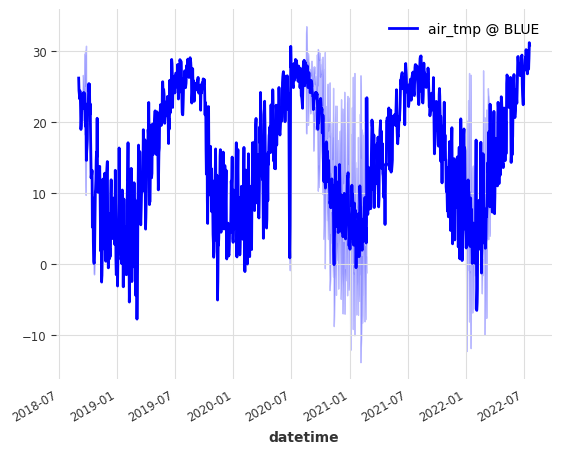

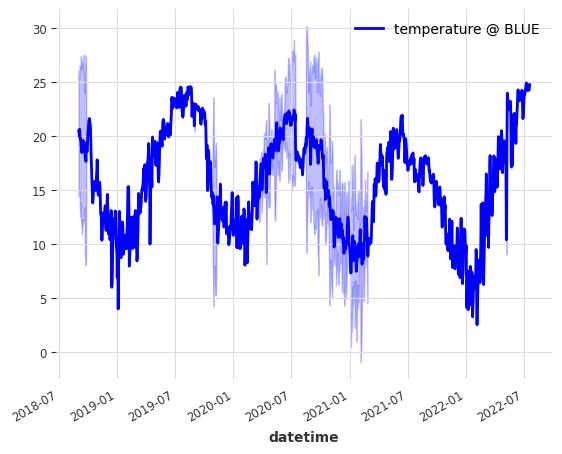

/home/rstudio/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


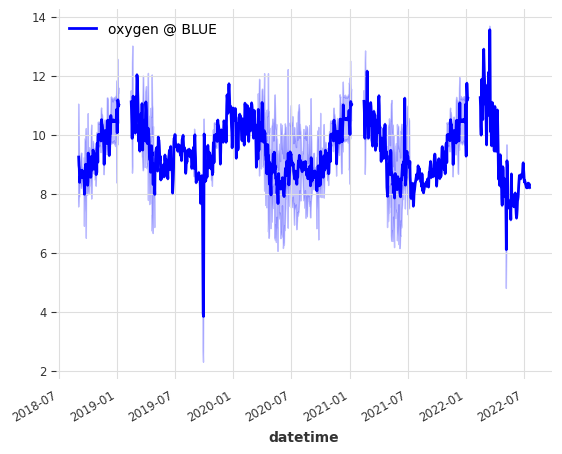

In [69]:
data_preprocessor.load('BLUE')
data_preprocessor.plot_by_site('BLUE')

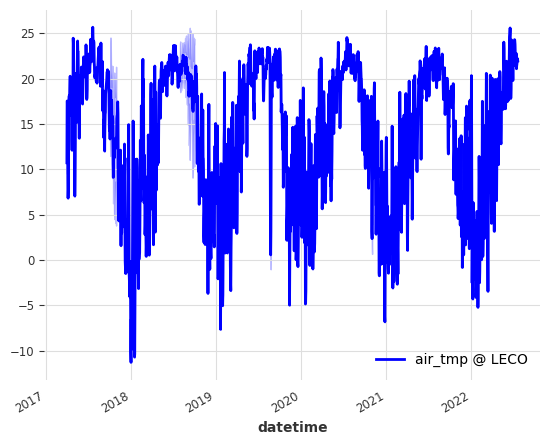

/home/rstudio/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


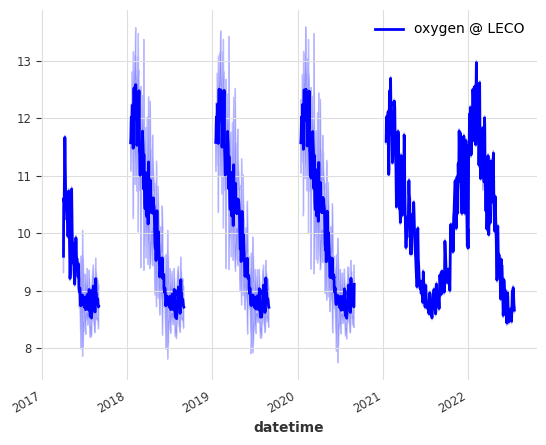

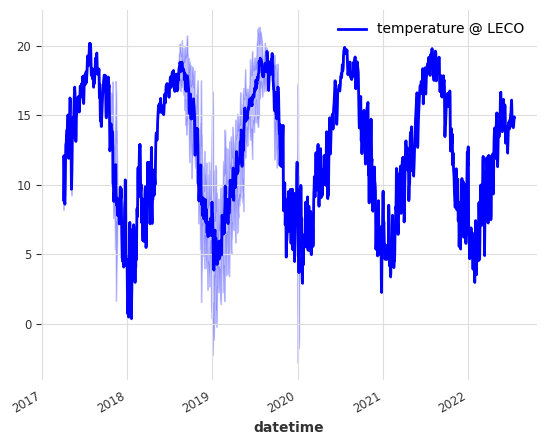

In [68]:
data_preprocessor.load('LECO')
data_preprocessor.plot_by_site('LECO')

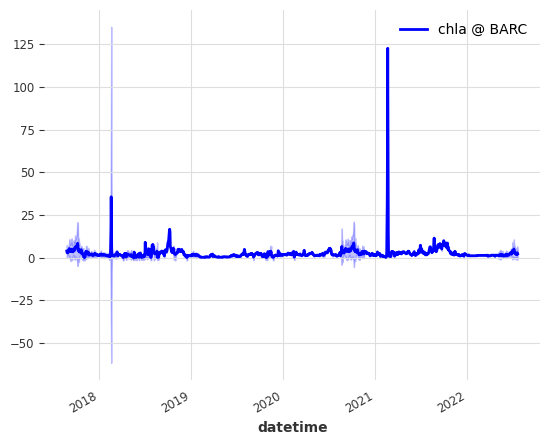

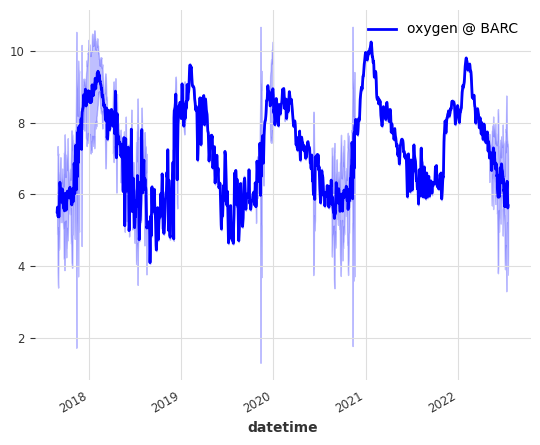

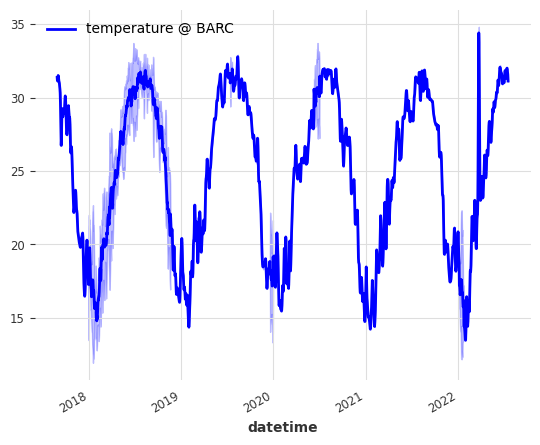

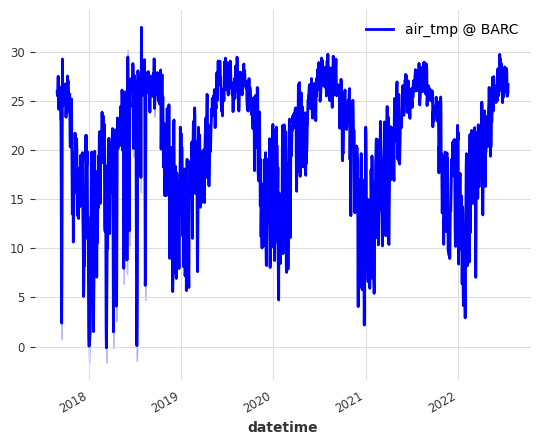

In [59]:
data_preprocessor.plot_by_site('BARC')

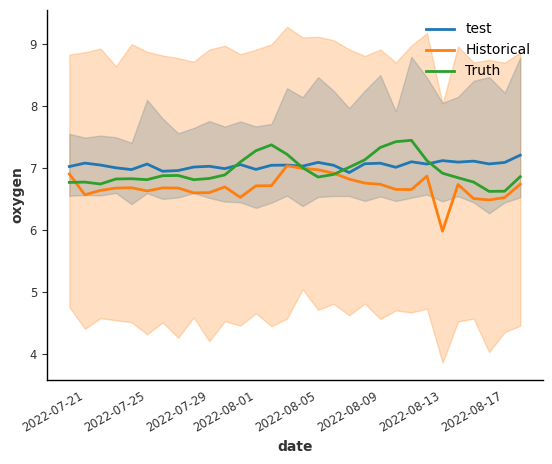

In [5]:
plot_forecasts(['test'], '2022_07_20', targets, 'FLNT', 'oxygen')

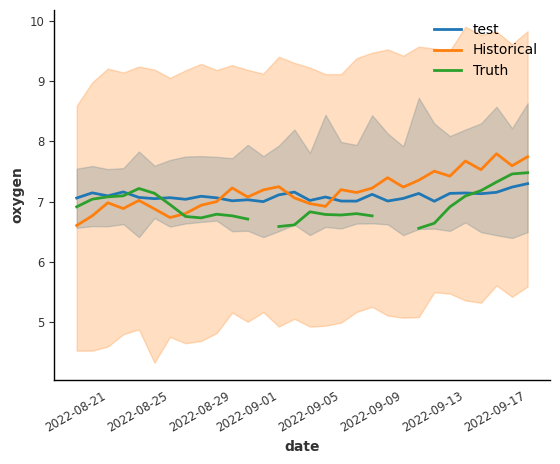

In [6]:
plot_forecasts(['test'], '2022_08_19', targets, 'FLNT', 'oxygen')

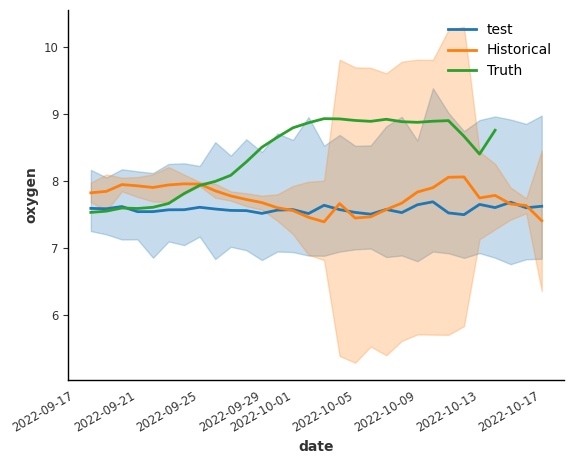

In [7]:
plot_forecasts(['test'], '2022_09_18', targets, 'FLNT', 'oxygen')

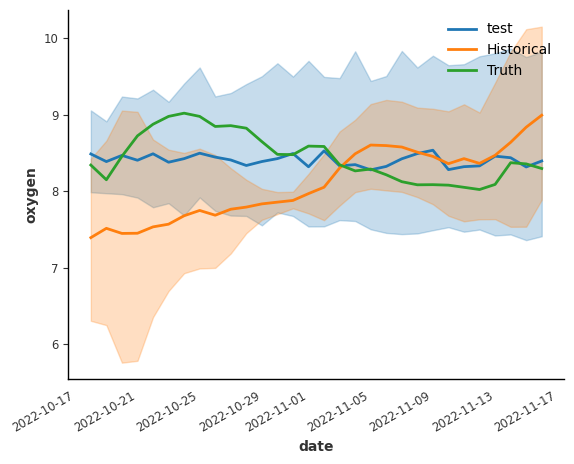

In [8]:
plot_forecasts(['test'], '2022_10_18', targets, 'FLNT', 'oxygen')

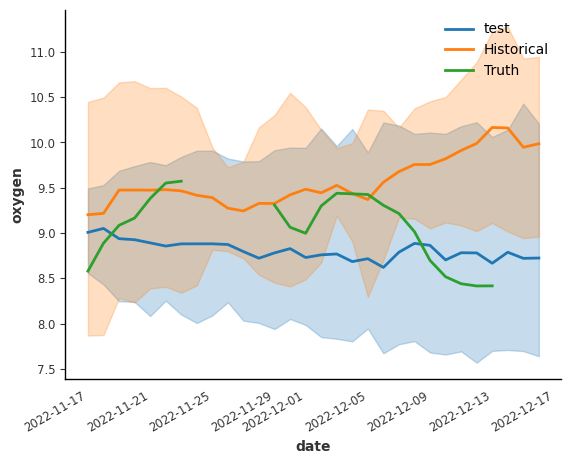

In [9]:
plot_forecasts(['test'], '2022_11_17', targets, 'FLNT', 'oxygen')

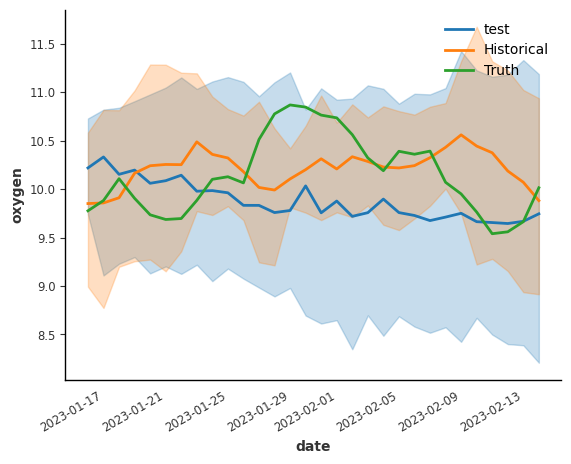

In [12]:
plot_forecasts(['test'], '2023_01_16', targets, 'FLNT', 'oxygen')

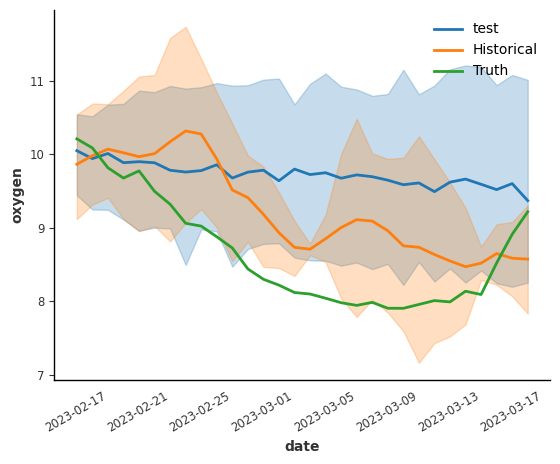

In [13]:
plot_forecasts(['test'], '2023_02_15', targets, 'FLNT', 'oxygen')

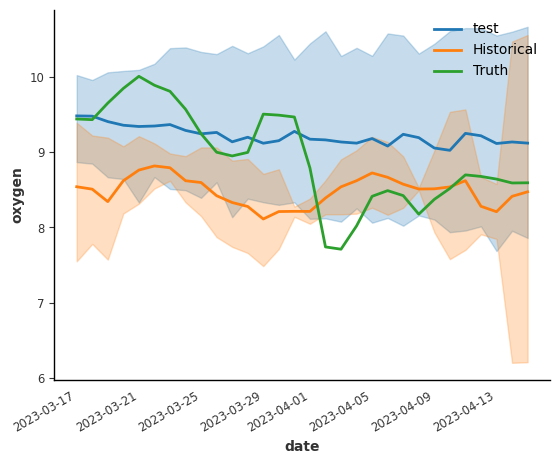

In [14]:
plot_forecasts(['test'], '2023_03_17', targets, 'FLNT', 'oxygen')

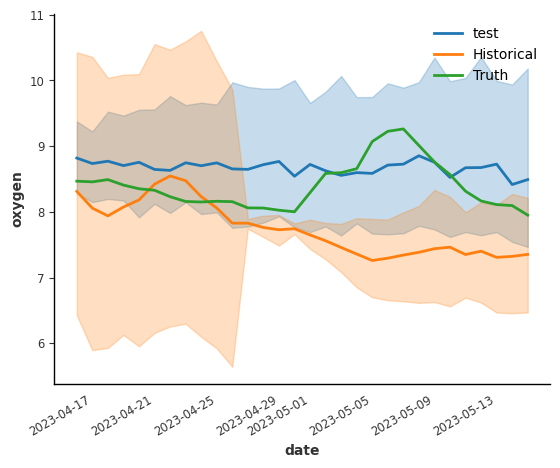

In [15]:
plot_forecasts(['test'], '2023_04_16', targets, 'FLNT', 'oxygen')

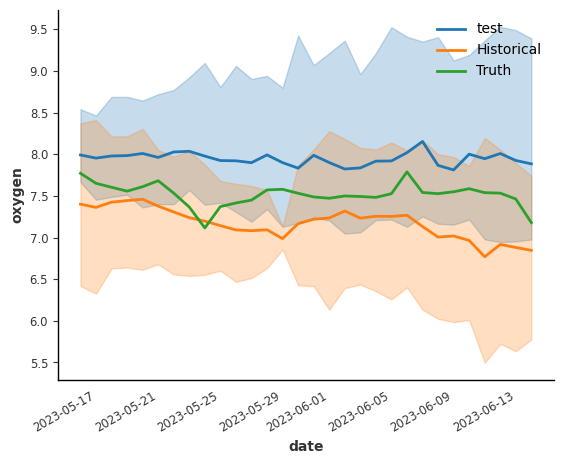

In [16]:
plot_forecasts(['test'], '2023_05_16', targets, 'FLNT', 'oxygen')

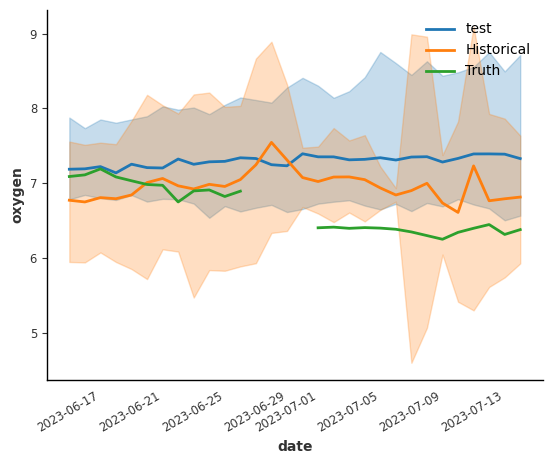

In [18]:
plot_forecasts(['test'], '2023_06_15', targets, 'FLNT', 'oxygen')

In [46]:
def plot_forecasts(prefix_list, date, targets_df, site_id, target_variable, plot_name=None):
    cmap = mpl.colormaps["tab10"]
    colors = cmap.colors
    # Loading the forecast csv and creating a time series
    for i, prefix in enumerate(prefix_list):
        csv_name = f"{prefix}_{date}.csv"
        df = pd.read_csv(csv_name)
        times = pd.to_datetime(df["datetime"])
        times = pd.DatetimeIndex(times)
        values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
        model_forecast = TimeSeries.from_times_and_values(times, 
                                                          values, 
                                                          fill_missing_dates=True, freq="D")
        model_forecast.plot(label=f"{prefix}", color=colors[i])

    # Getting the validation series directly from the targets csv
    date = model_forecast.time_index[0]
    forecast_horizon = len(model_forecast)
    validation_series = get_validation_series(
        targets_df, 
        site_id, 
        target_variable, 
        date, 
        forecast_horizon
    )

    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(
        targets=targets_df,
        site_id=site_id,
        target_variable=target_variable,
        output_csv_name="historical_forecaster_output.csv",
        validation_split_date=str(model_forecast.time_index[0])[:10],
        forecast_horizon=len(model_forecast),
    )
    historical_model.make_forecasts()
    i += 1
    historical_model.forecast_ts.plot(label="Historical", color=colors[i])
    validation_series.plot(label="Truth", color=colors[i+1])
    x = plt.xlabel("date")
    y = plt.ylabel(target_variable)
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.grid(False)

    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

In [47]:
def get_validation_series(targets_df, site_id, target_variable, date, forecast_horizon):
    # Being careful here with the date, note that I am matching the forecast,
    # so I don't need to advance.
    date_range = pd.date_range(date, 
                               periods=forecast_horizon, 
                               freq='D')
    # Filter targets df for site and variable
    site_df = targets_df[targets_df["site_id"] == site_id]
    site_var_df_ = site_df[["datetime", target_variable]]
    site_var_df = site_var_df_.copy()
    site_var_df["datetime"] = pd.to_datetime(site_var_df_["datetime"])
    validation_df = pd.DataFrame()
    # Now creating a new dataframe of observed series from the forecast
    # window
    for date in date_range:
        entry = site_var_df[site_var_df.datetime == date]
        validation_df = pd.concat(
            [validation_df, entry], 
            axis=0
        ).reset_index(drop=True)
        
    times = pd.to_datetime(validation_df.datetime)
    times = pd.DatetimeIndex(times)
    validation_series = TimeSeries.from_times_and_values(
        times,
        validation_df[[target_variable]],
        fill_missing_dates=True,
        freq="D",
    )
    
    return validation_series

def filter_forecast_df(forecast_df, validation_series):
    """
    Assumes validation series is a TimeSeries
    and forecast_df has an datetime index
    """
    gaps = validation_series.gaps()
    # Filtering forecast df to only include dates in the validation series
    if len(gaps) > 0:
        for i in range(len(gaps)):
            gap_start = gaps.iloc[i].gap_start
            gap_end = gaps.iloc[i].gap_end
            forecast_df = forecast_df[(forecast_df.index < gap_start) \
                                      | (forecast_df.index > gap_end)]

    times = forecast_df.index
    validation_series = validation_series.pd_series().dropna()
    # Checking that the dates indices are the same, i.e. that filtering worked properly
    assert (validation_series.index == forecast_df.index).all()

    values = forecast_df.loc[:, forecast_df.columns!="datetime"].to_numpy().reshape(
                                                                (len(times), 1, -1))
    filtered_forecast_ts = TimeSeries.from_times_and_values(
        times, 
        values, 
    )

    return filtered_forecast_ts, validation_series

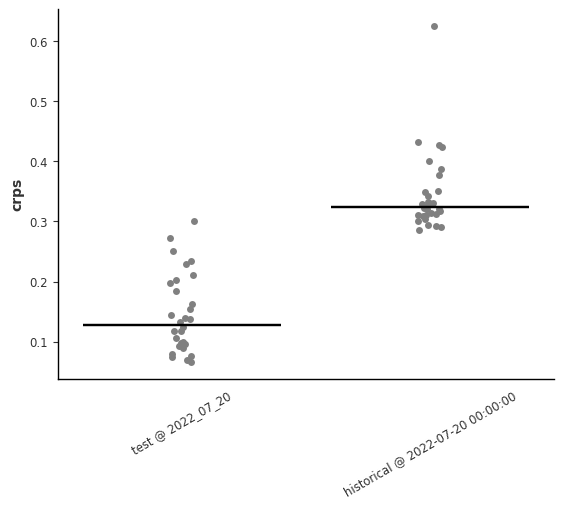

In [27]:
plot_crps_strip(['2022_07_20'], 'test', targets, 'FLNT', 'oxygen')

In [26]:
def plot_crps_strip(date_list, prefix, targets_df, site_id, target_variable, plot_name=None):
    cmap = mpl.colormaps["tab20"]
    colors = cmap.colors
    score_dict = {}
    # Loading the forecast csv and creating a time series
    for i, date_str in enumerate(date_list):
        csv_name = f"{prefix}_{date_str}.csv"
        forecast_df = pd.read_csv(csv_name)
        forecast_df["datetime"] = pd.to_datetime(forecast_df["datetime"])
        times = pd.DatetimeIndex(forecast_df["datetime"])
        forecast_df = forecast_df.set_index("datetime")

        # Getting the validation set from targets
        if i == 0:
            date = forecast_df.index[0]
            forecast_horizon = len(forecast_df)
            validation_series = get_validation_series(
                targets_df, 
                site_id, 
                target_variable, 
                date, 
                forecast_horizon,
            )
        # Filter the forecast to only include dates with observations
        filtered_model_forecast, filtered_validation_series = filter_forecast_df(
            forecast_df,
            validation_series
        )
        # Computing CRPS and plotting it as well as its mean (dashed)
        scores = crps(
            filtered_model_forecast, 
            filtered_validation_series
        )
        key_name = prefix + " @ " + date.strftime('%Y_%m_%d')
        score_dict[key_name] = scores.pd_dataframe().values[:, 0]
            
        # Now, making the forecast based off of historical mean and std
        historical_model = HistoricalForecaster(targets=targets_df,
                              site_id=site_id,
                              target_variable=target_variable,
                              output_csv_name="historical_forecaster_output.csv",
                              validation_split_date=str(forecast_df.index[0])[:10],
                              forecast_horizon=len(forecast_df),)
        # Computing CRPS of historical forecast and plotting
        historical_model.make_forecasts()
        historical_forecast_df = historical_model.forecast_ts.pd_dataframe(
            suppress_warnings=True
        )
        filtered_historical_forecast, filtered_validation_series = filter_forecast_df(
            historical_forecast_df,
            validation_series
        )
        scores = crps(filtered_historical_forecast, filtered_validation_series)
        score_dict[f"historical @ {date}"] = scores.pd_dataframe().values[:, 0]

    # Now creating the plot
    p = sns.stripplot(score_dict, jitter=0.05, color='0.5')

    # plot the mean line
    sns.boxplot(
        showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True, 'lw':1.75},
        whiskerprops={'visible': False},
        zorder=10,
        data=score_dict,
        showfliers=False,
        showbox=False,
        showcaps=False,
        ax=p
    )
    plt.grid(False)
    plt.ylabel("crps")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    
    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.
ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.
ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with miss

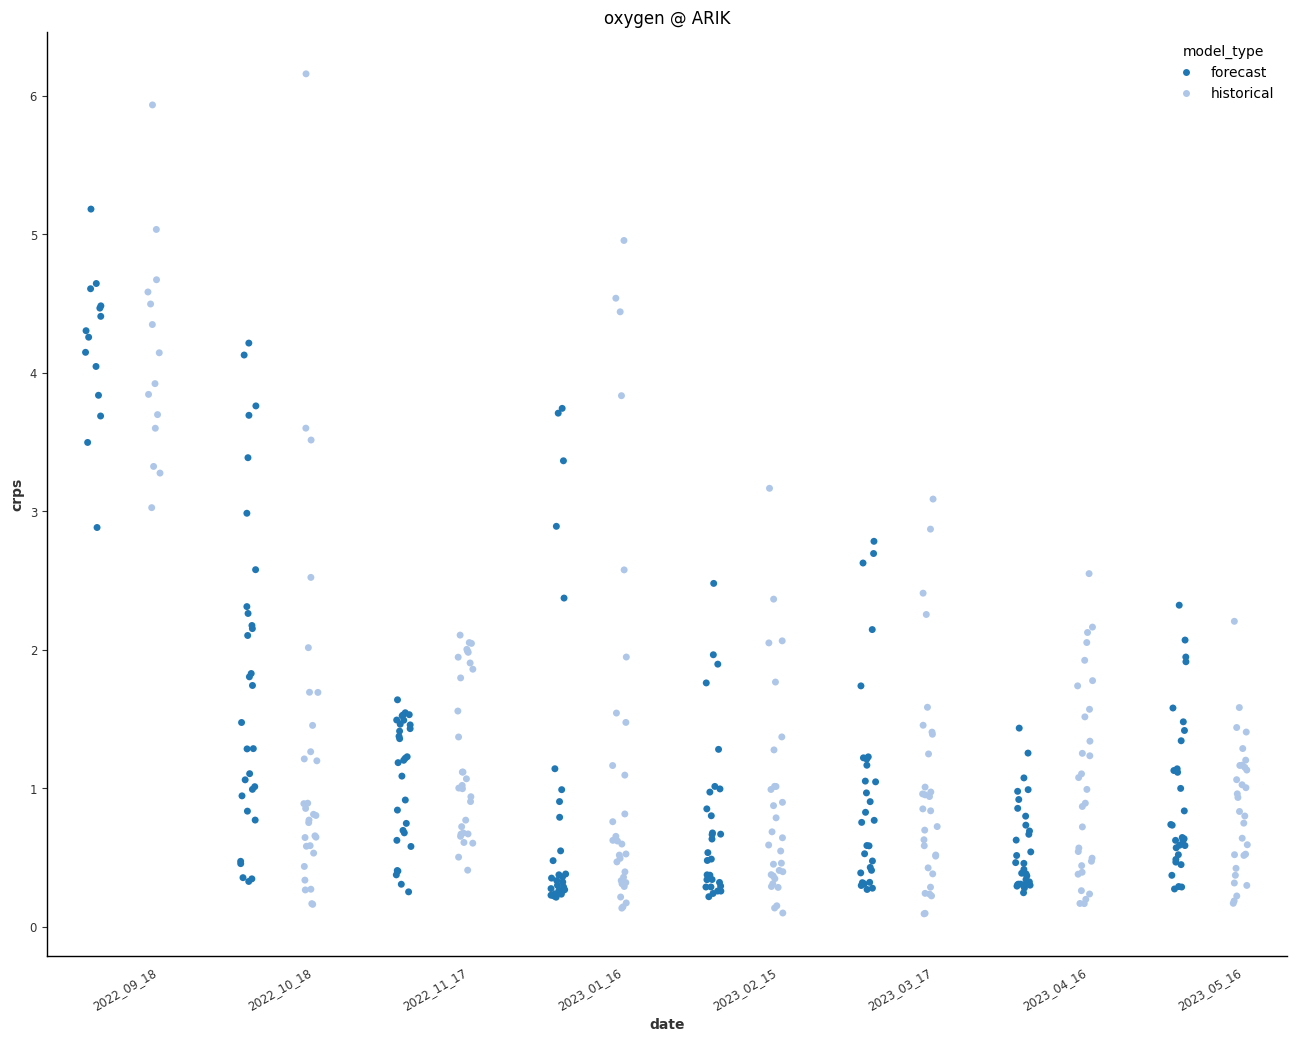

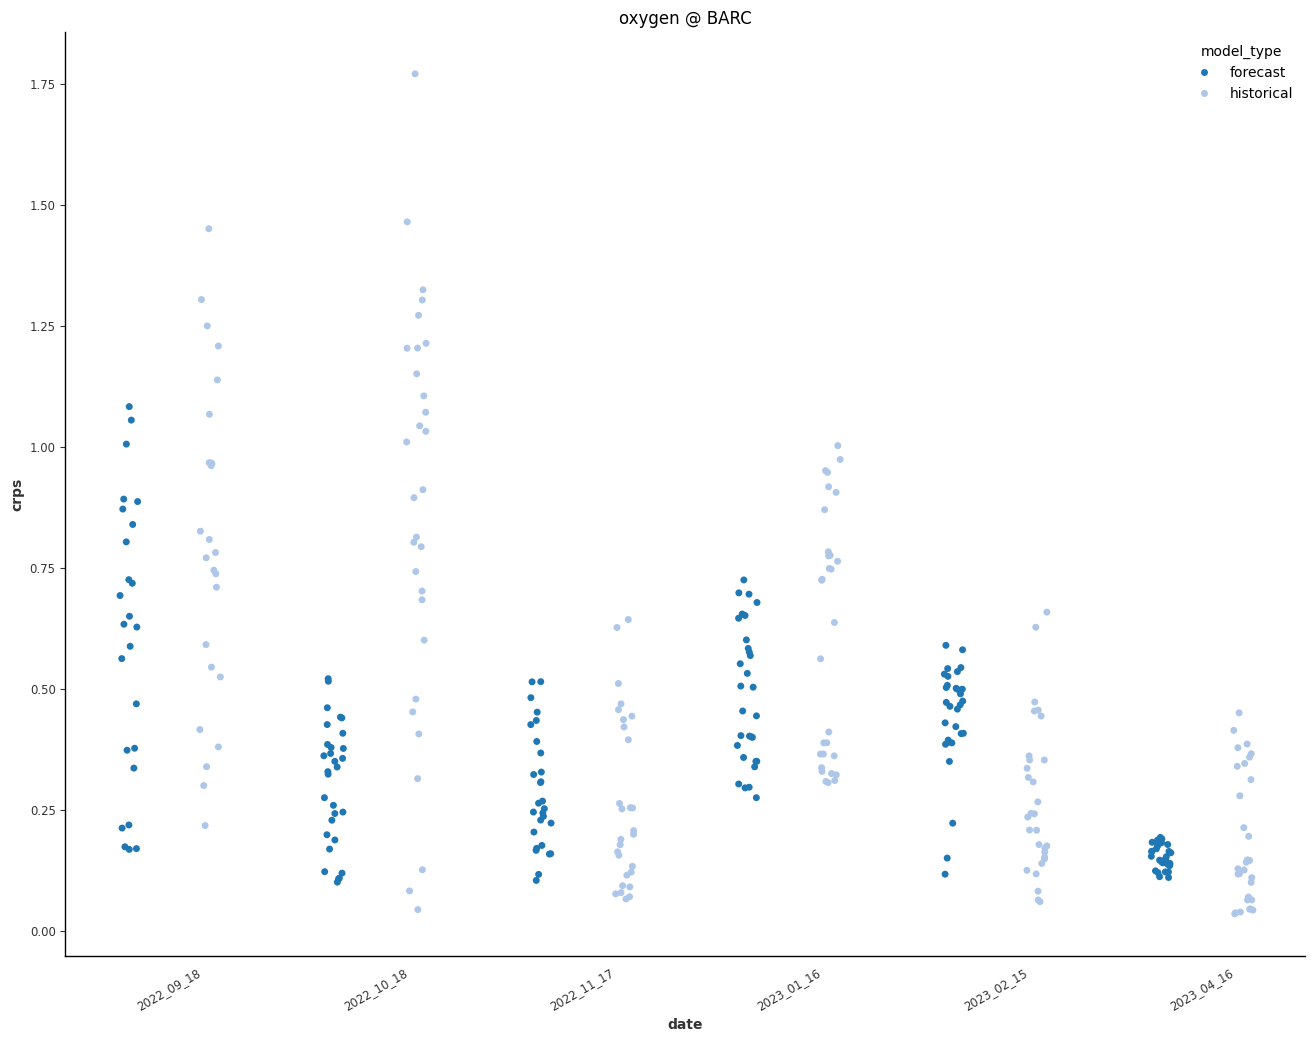

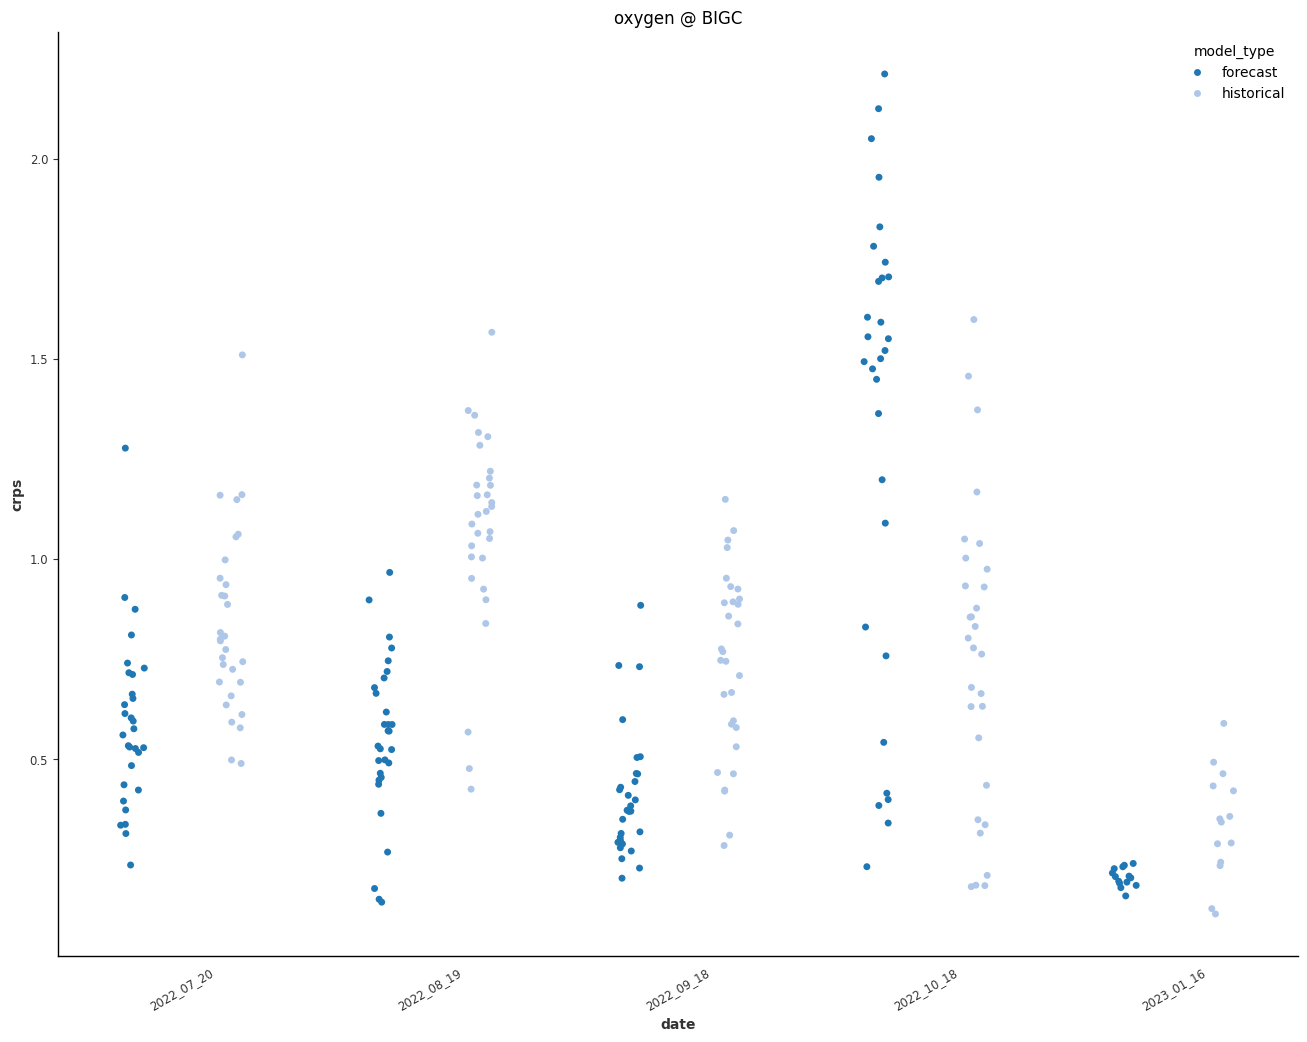

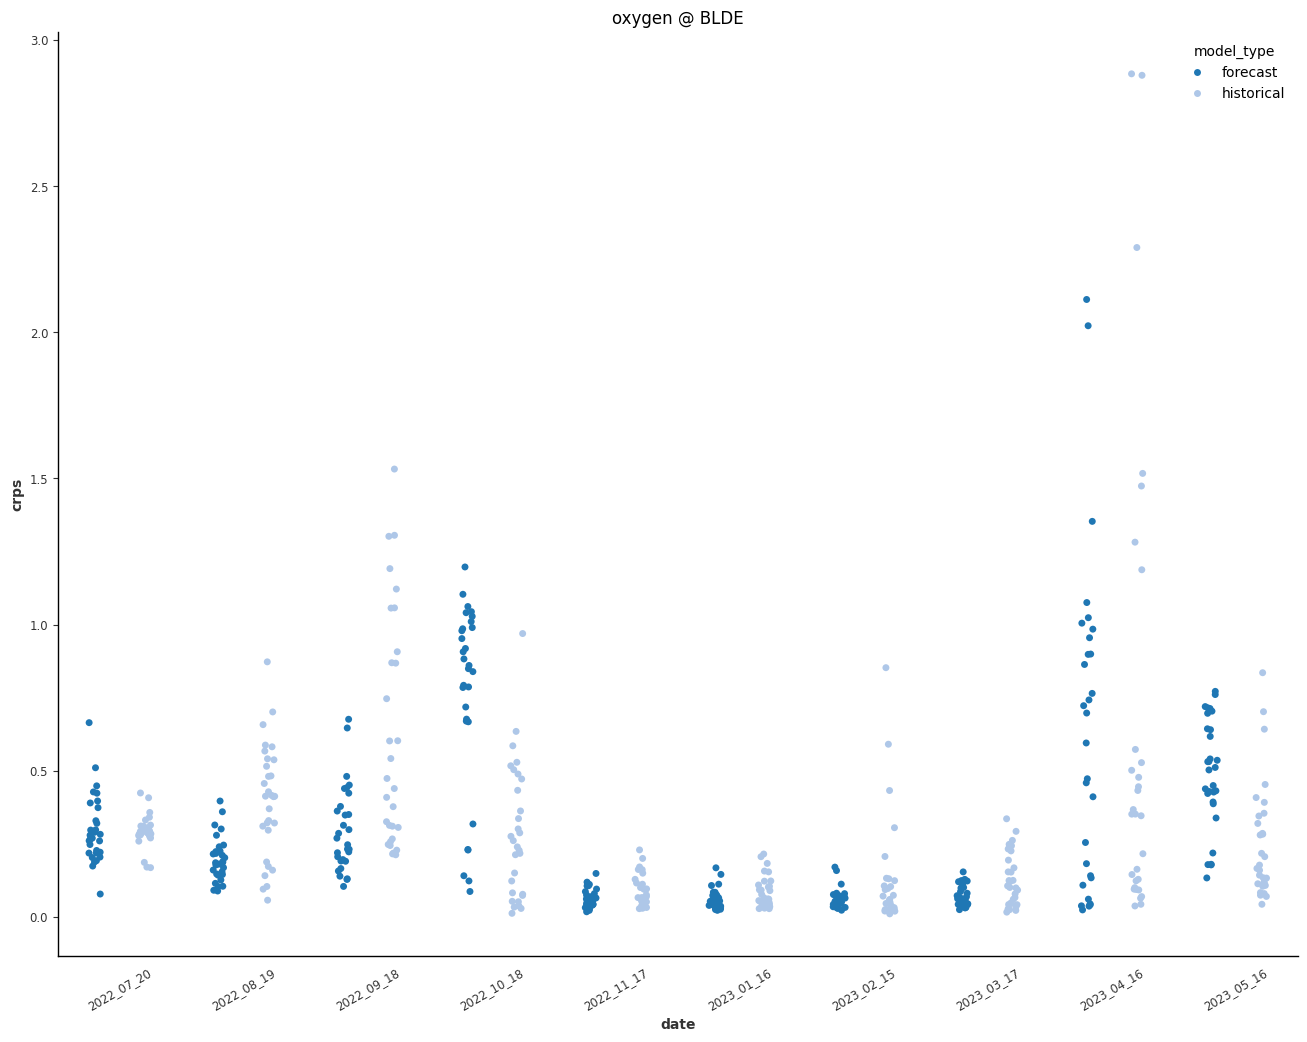

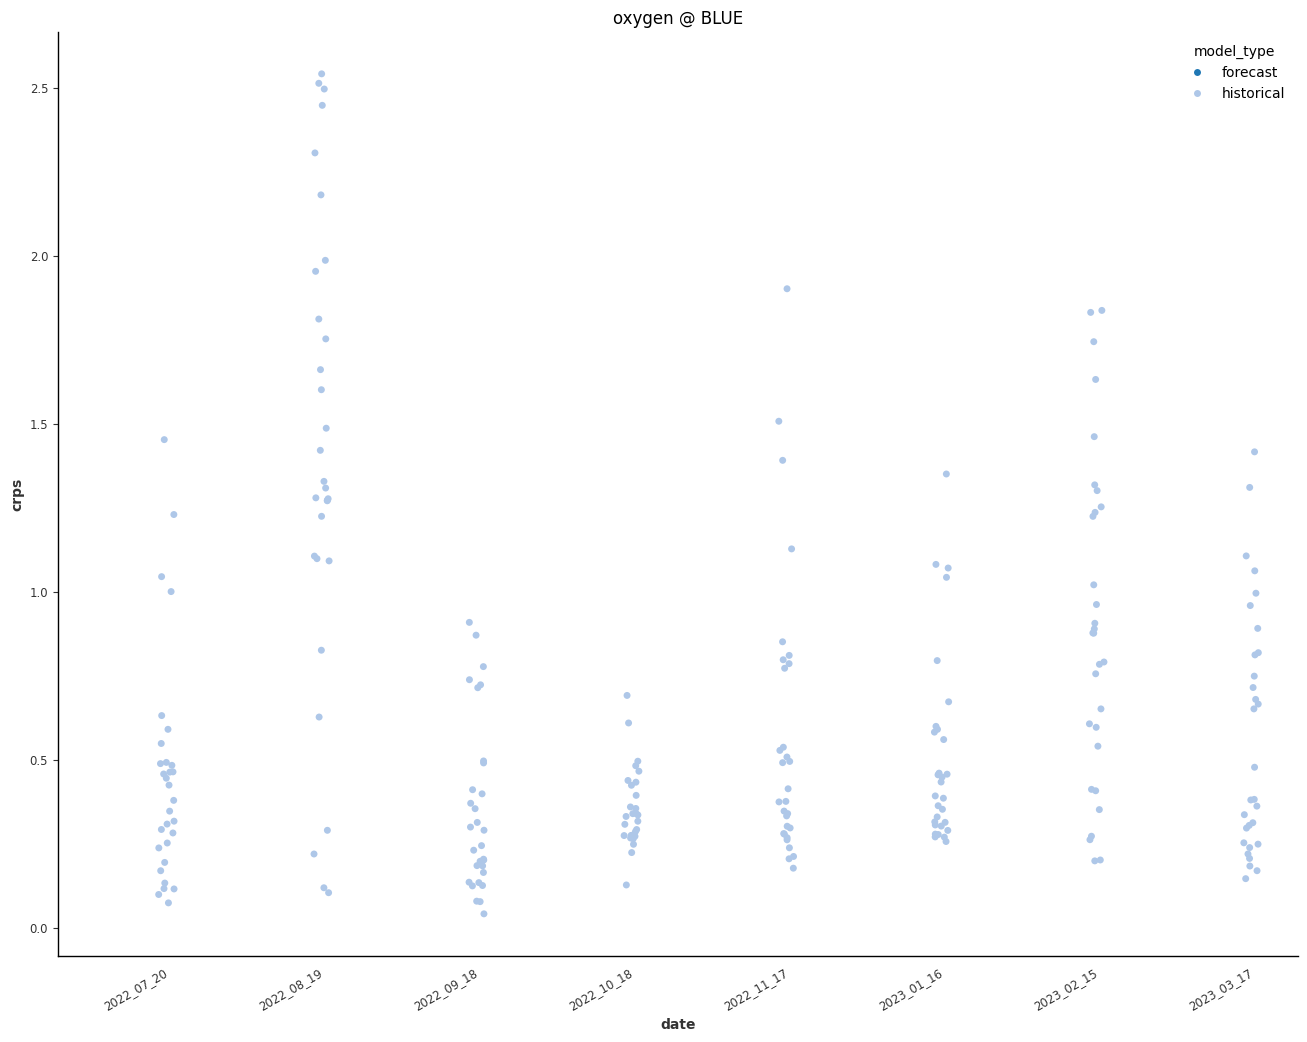

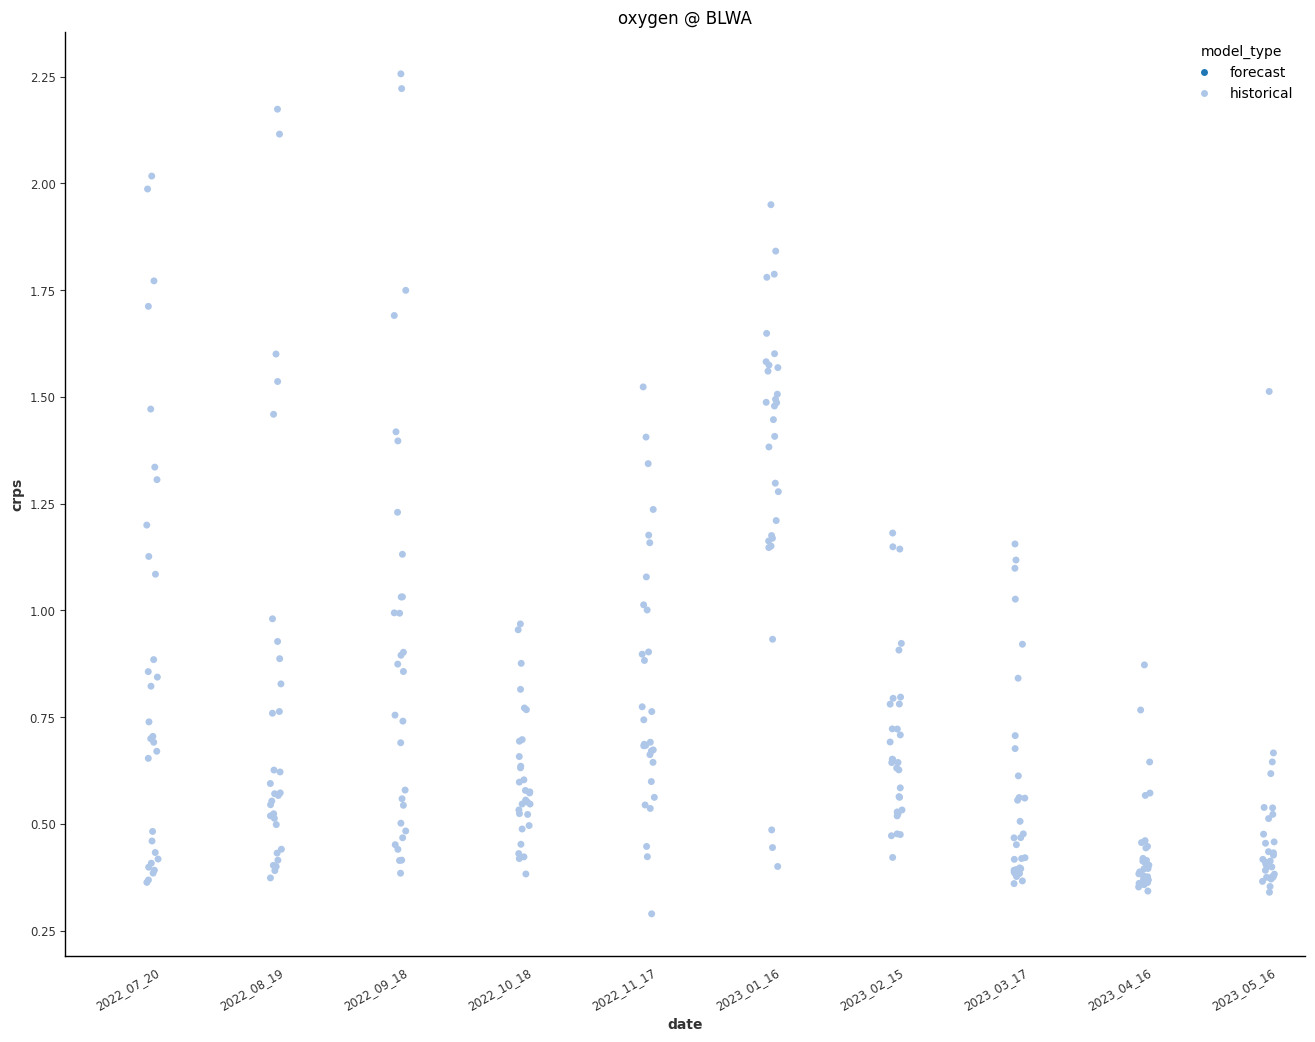

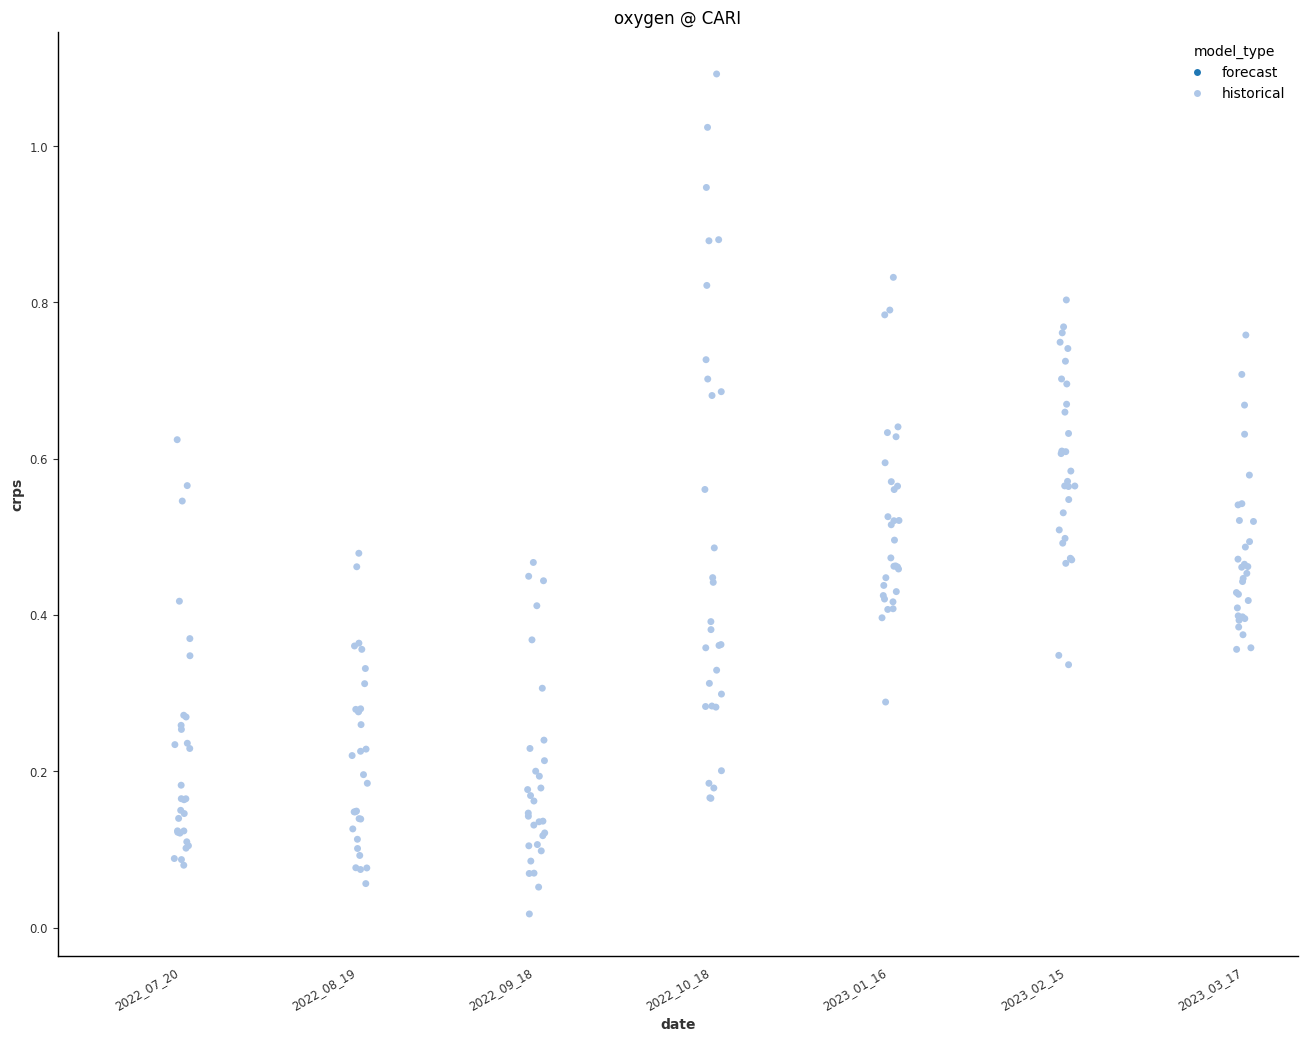

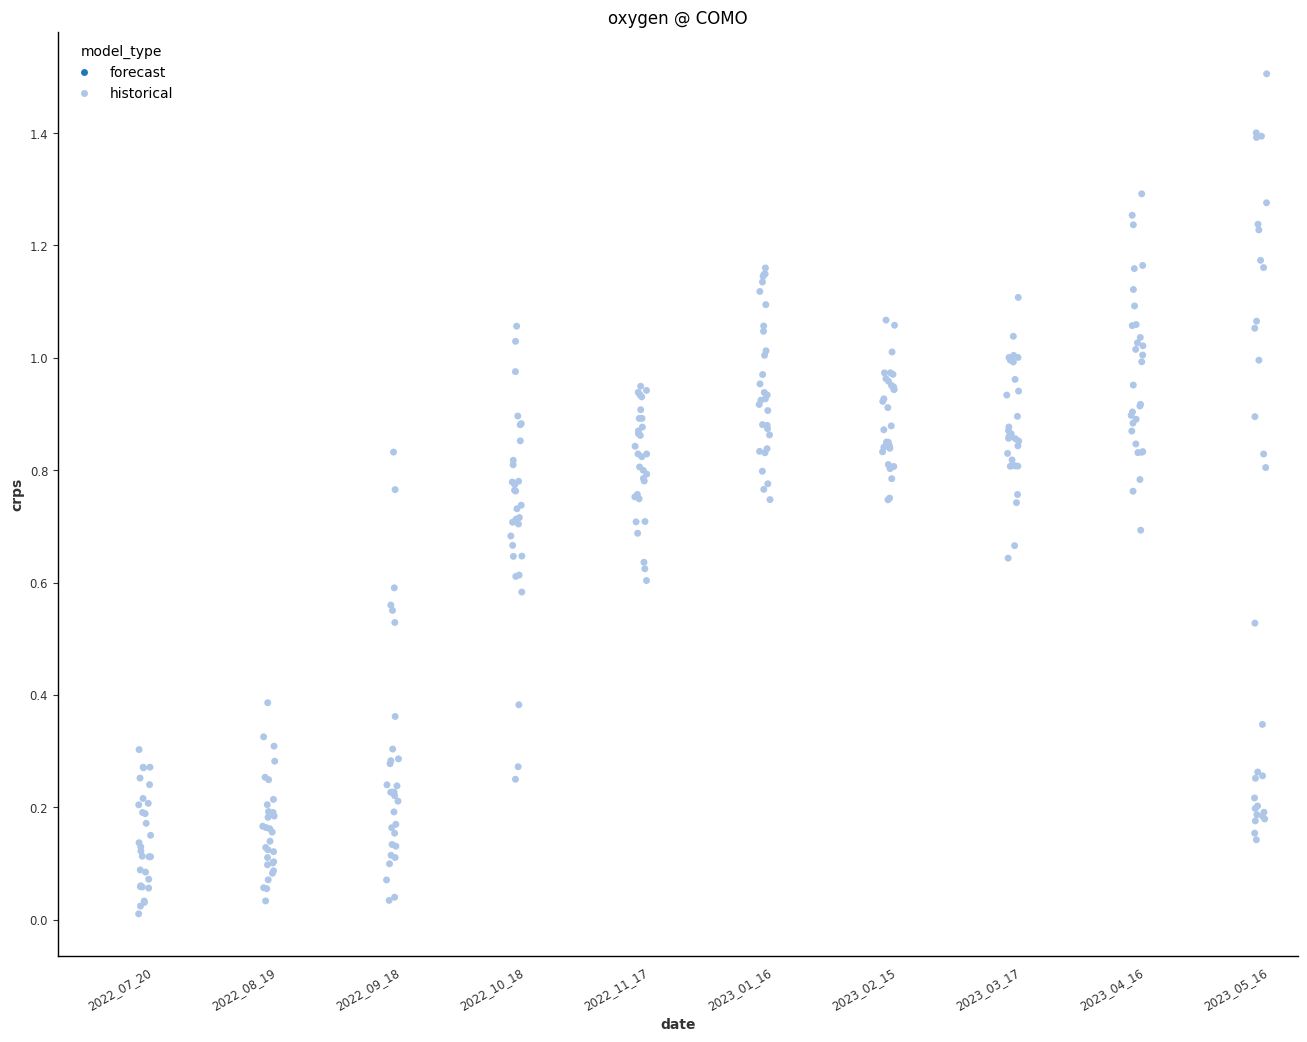

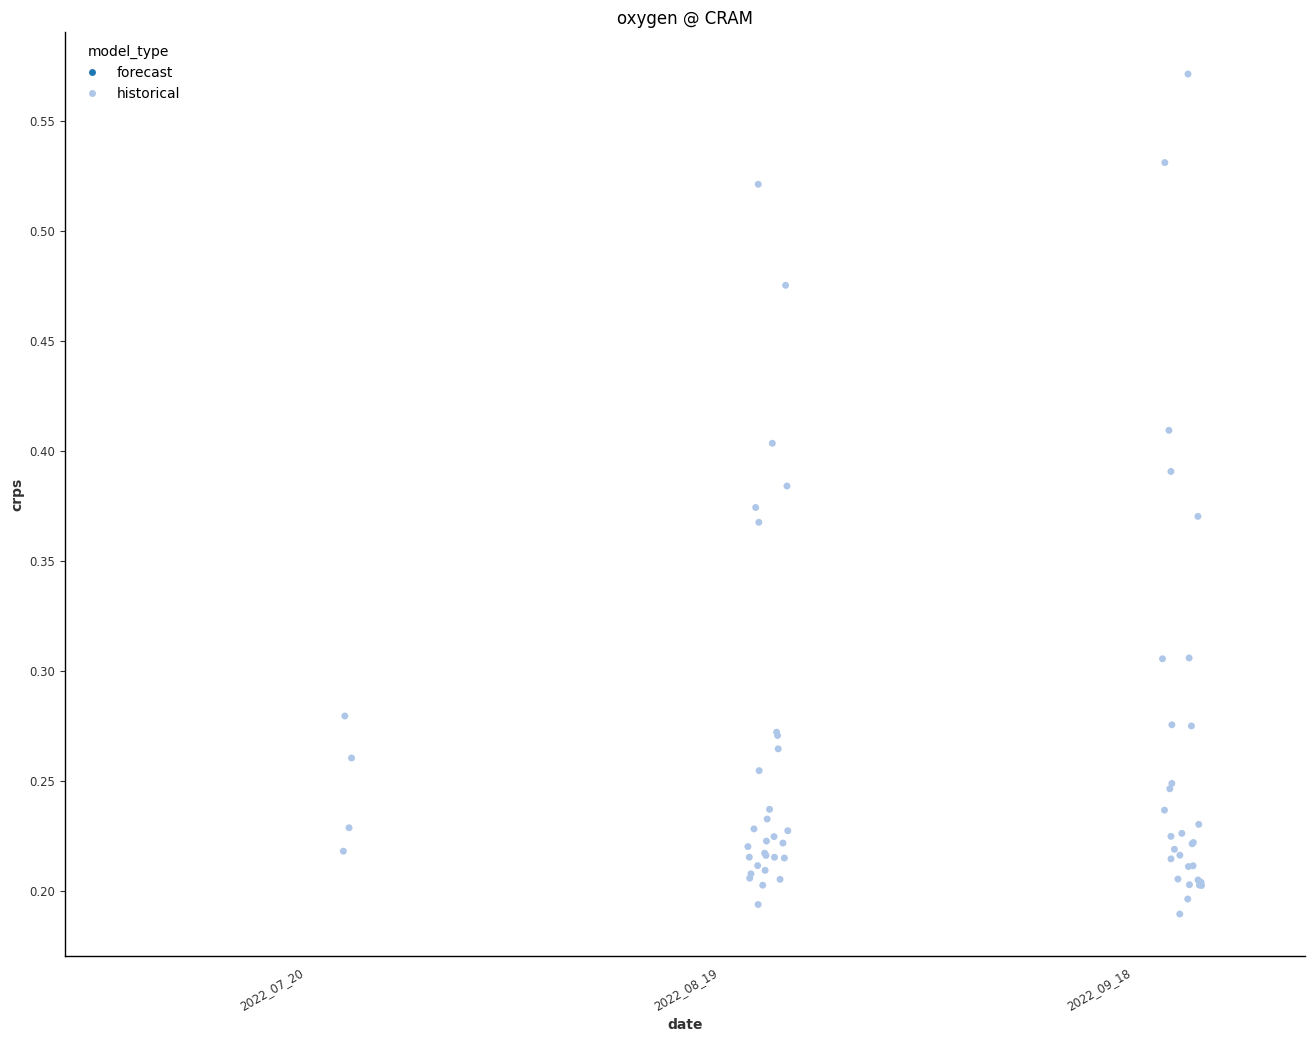

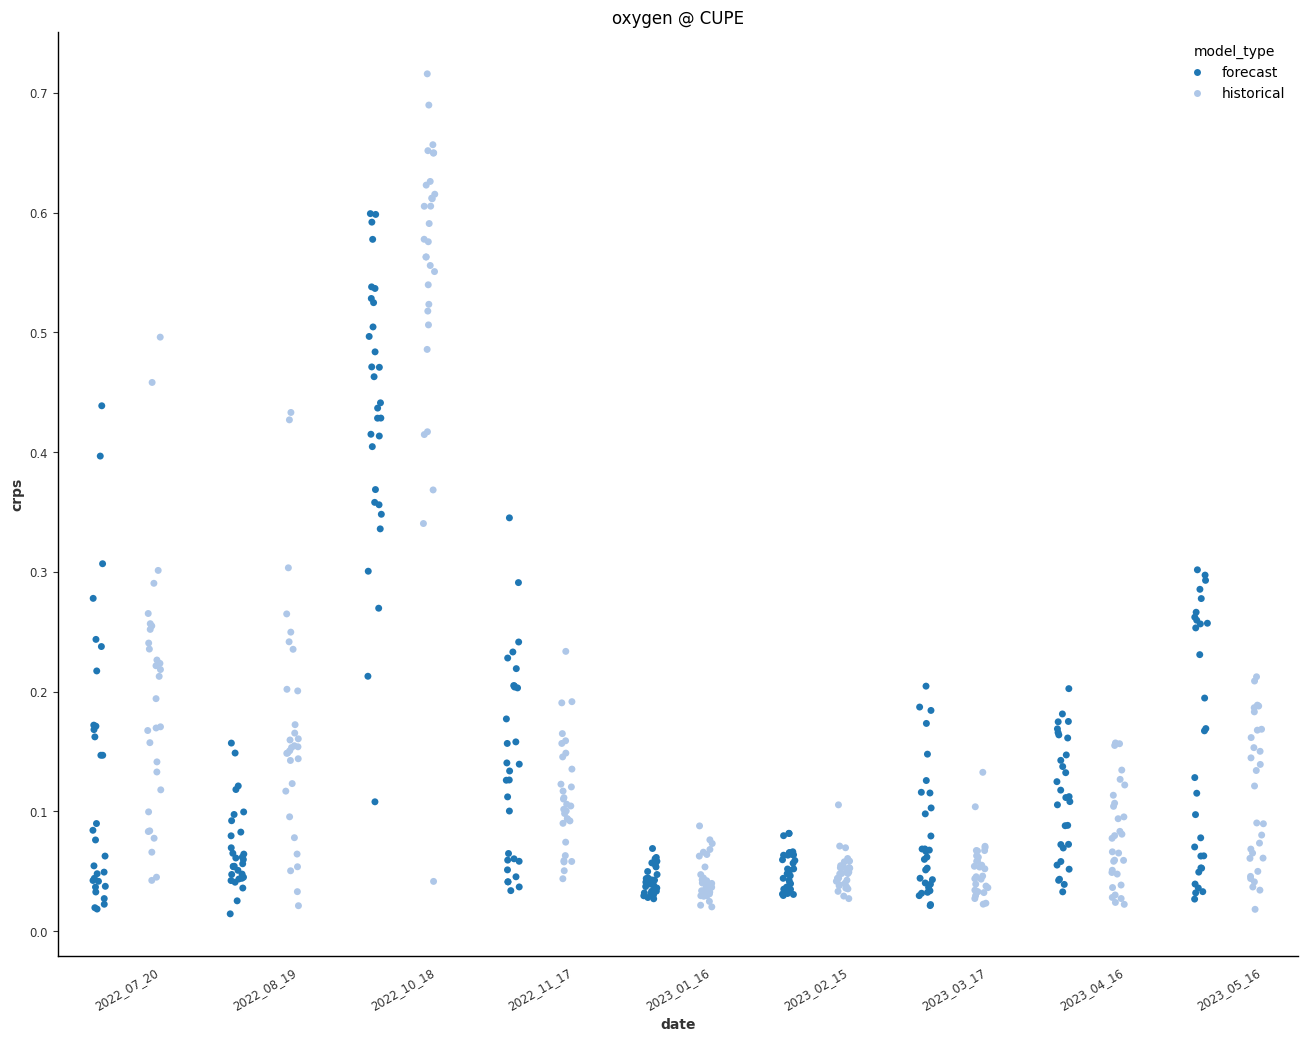

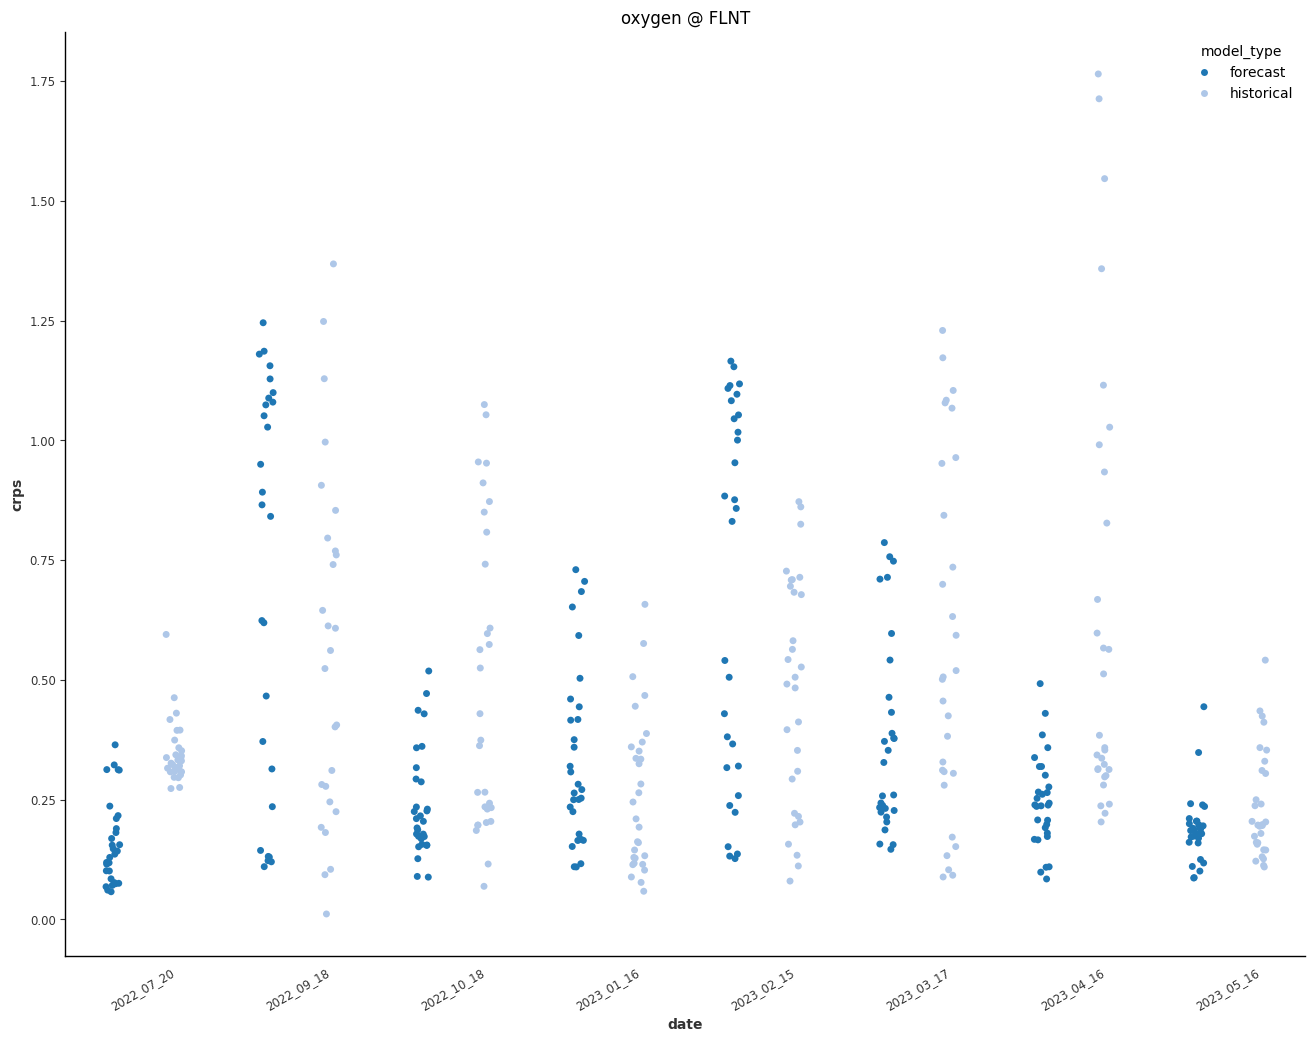

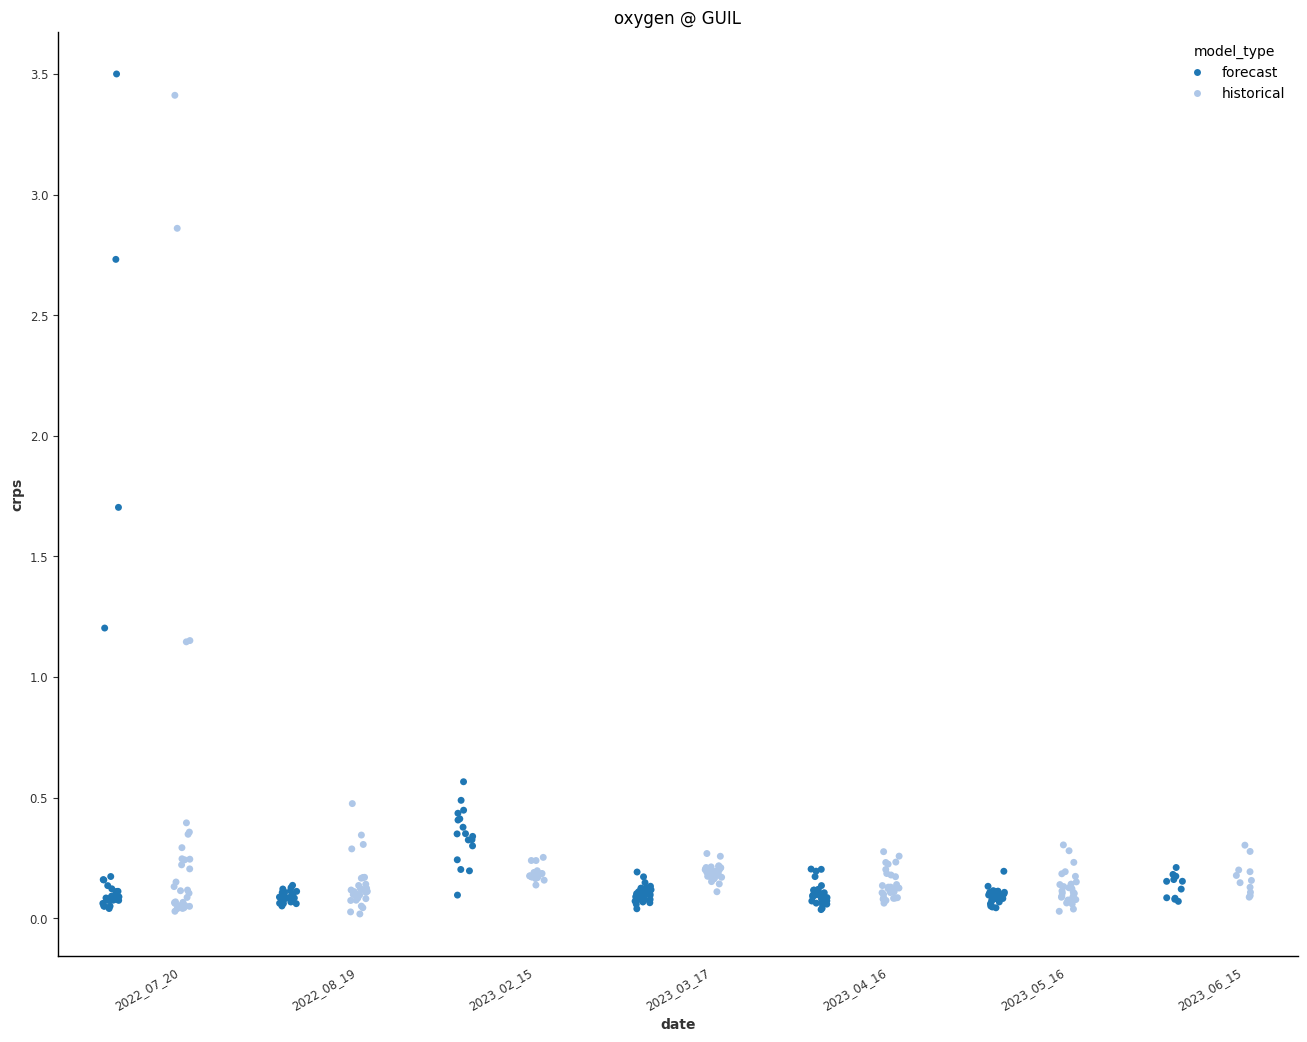

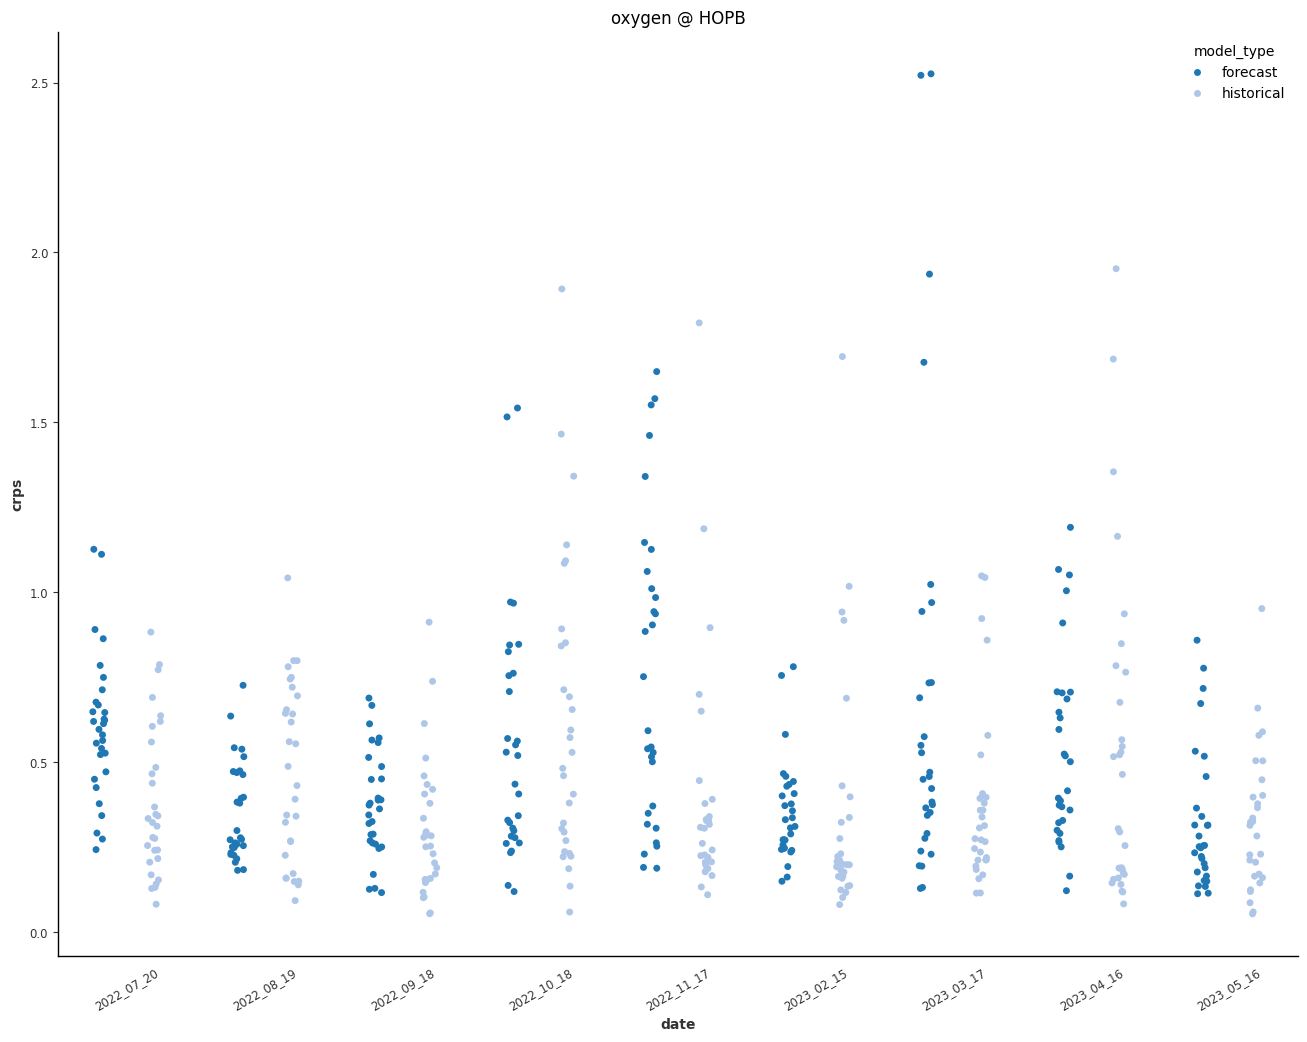

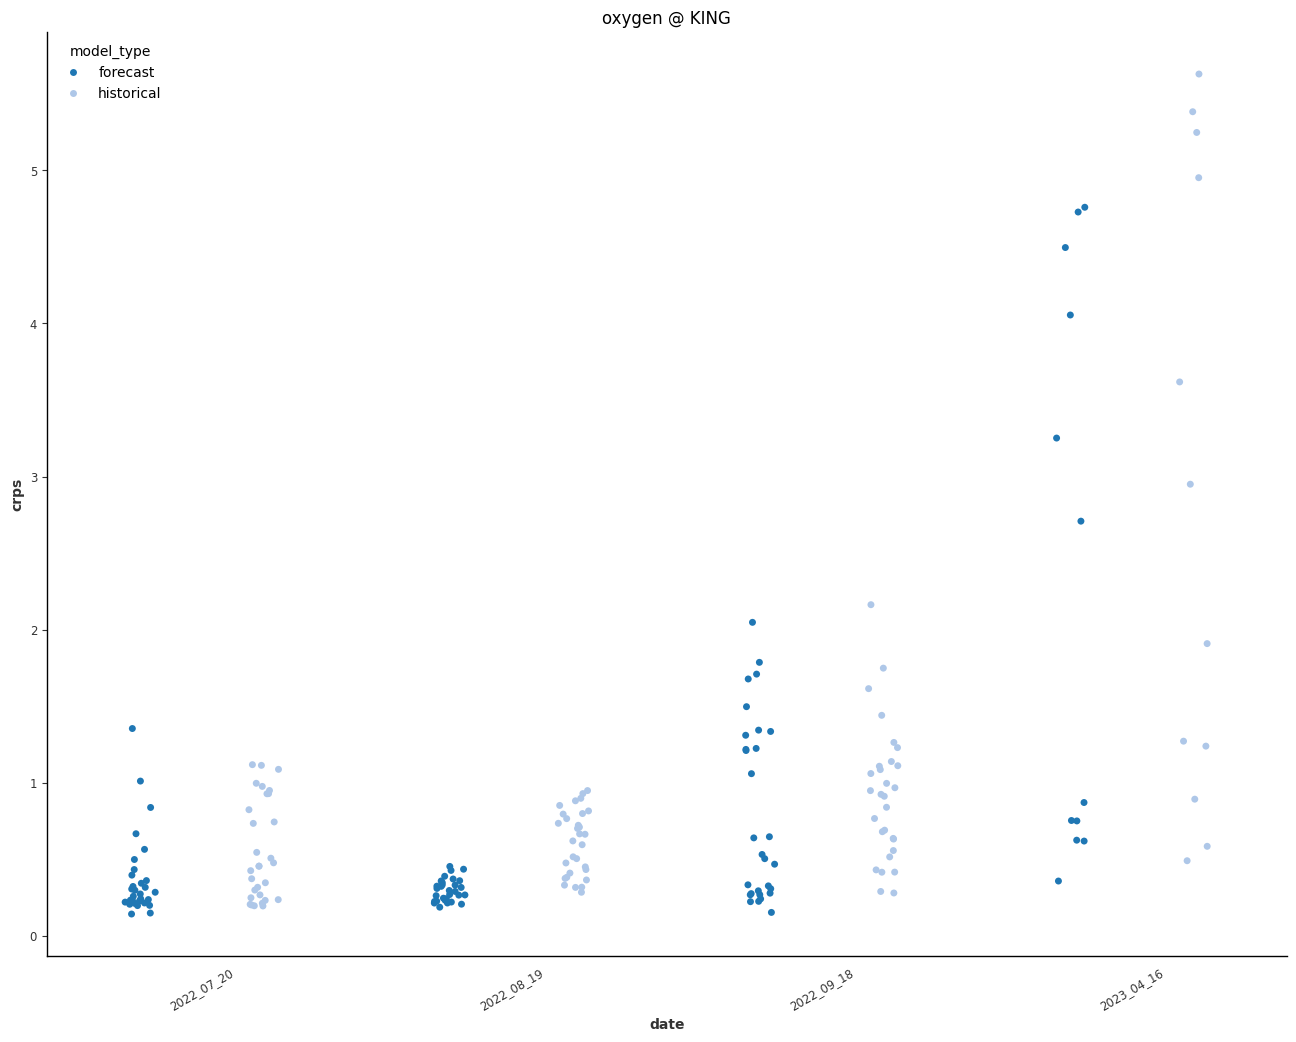

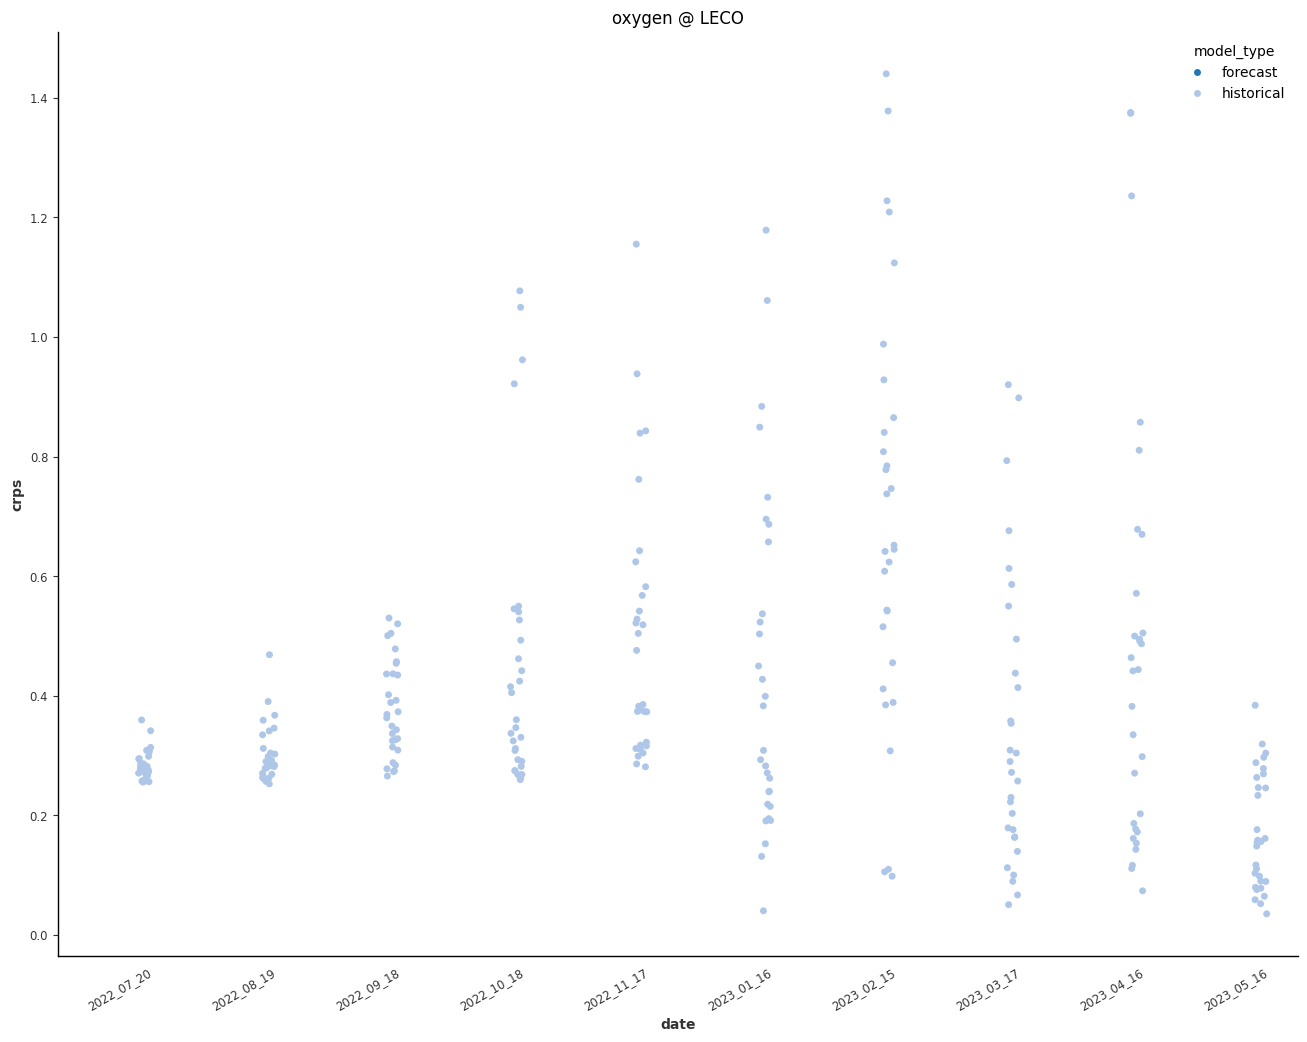

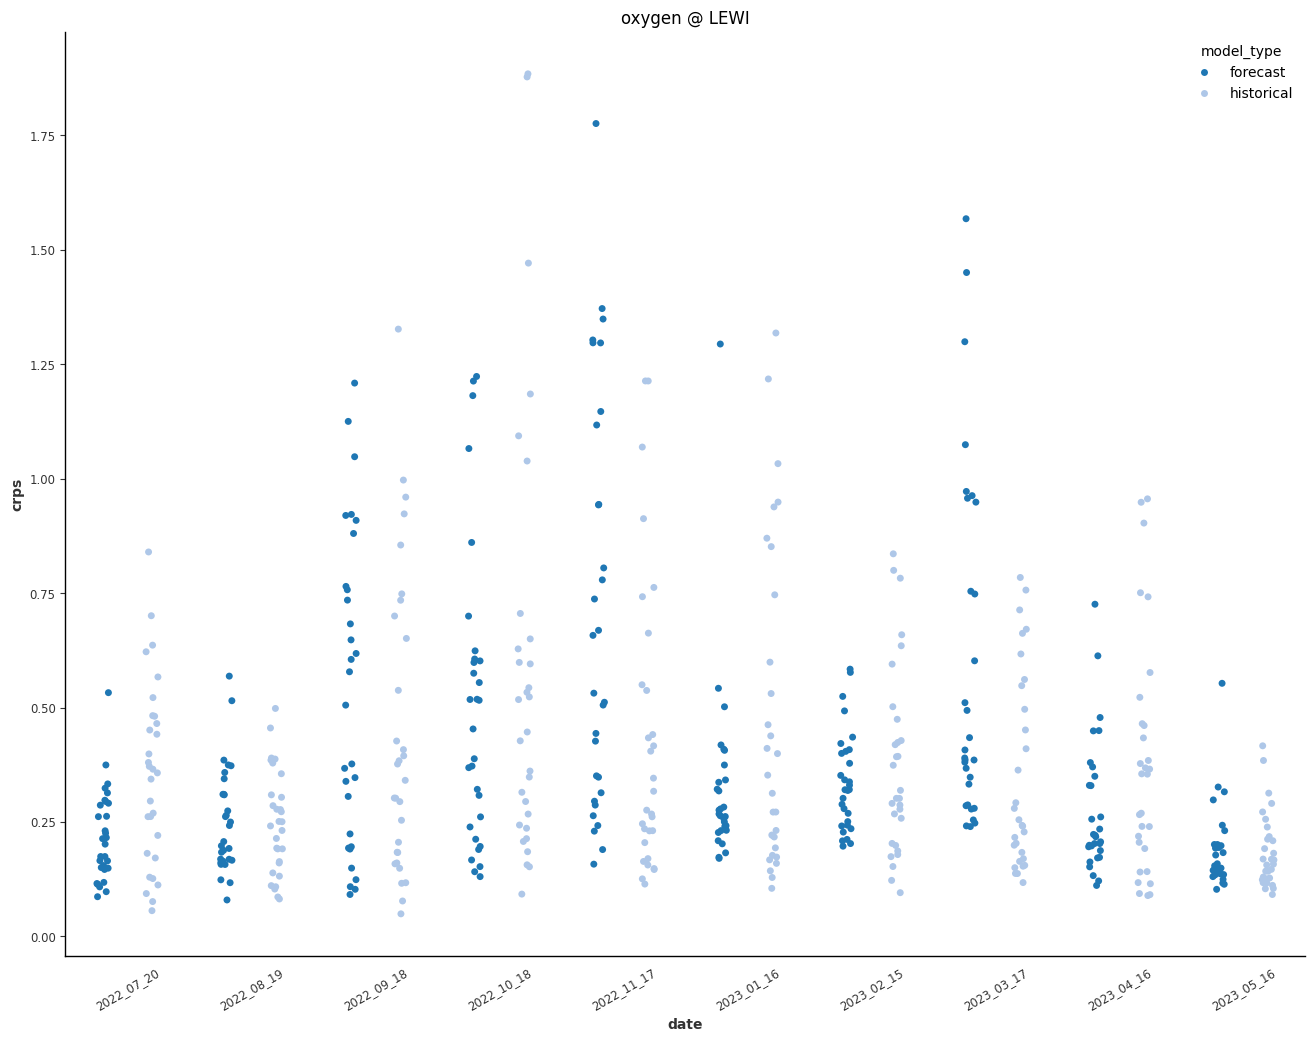

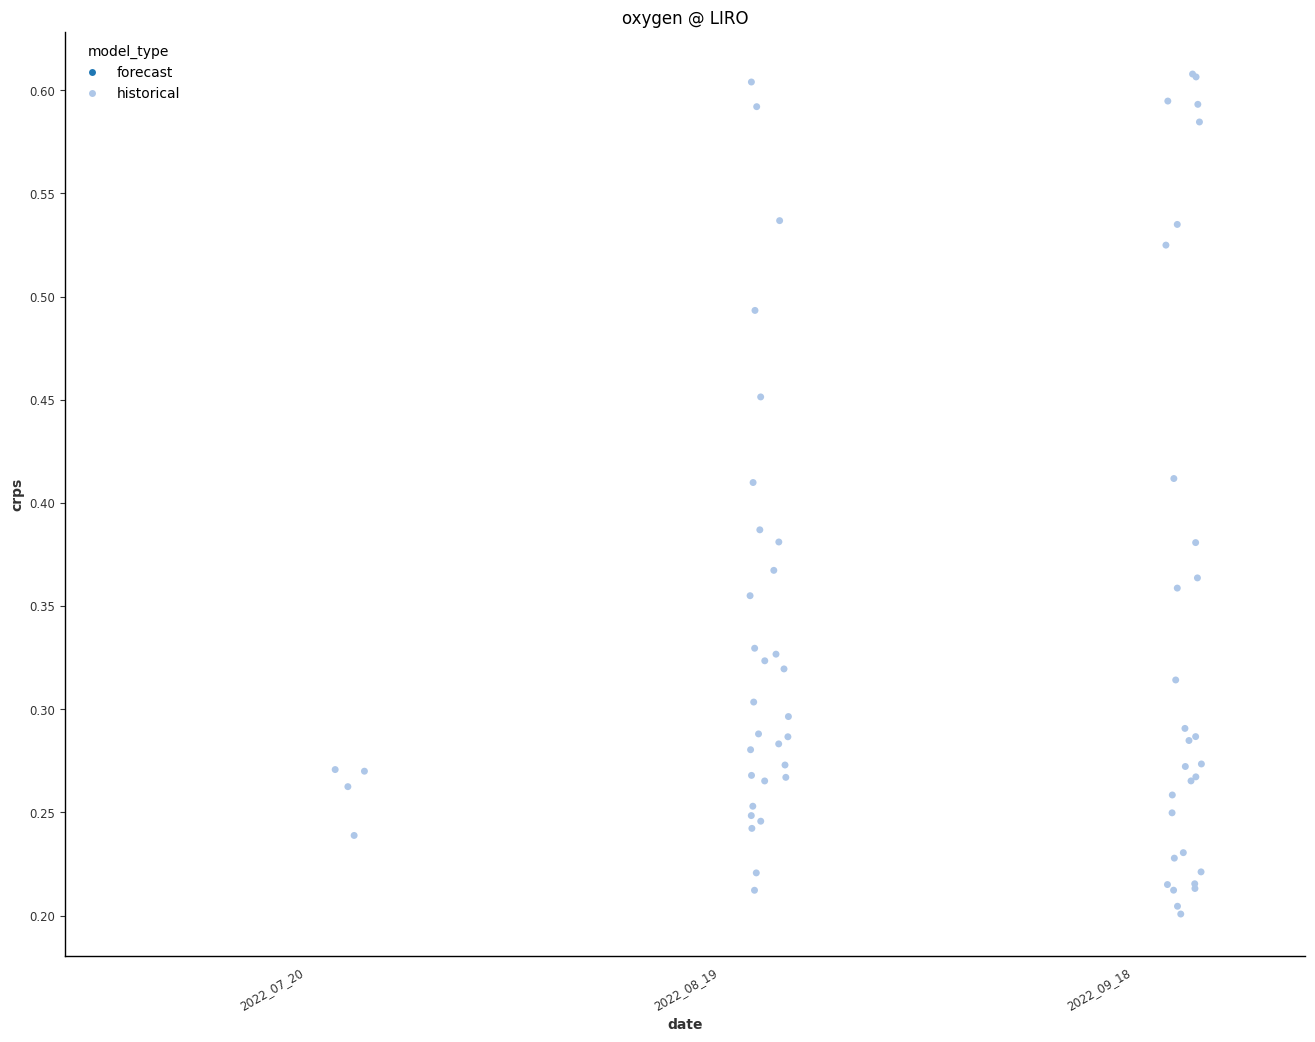

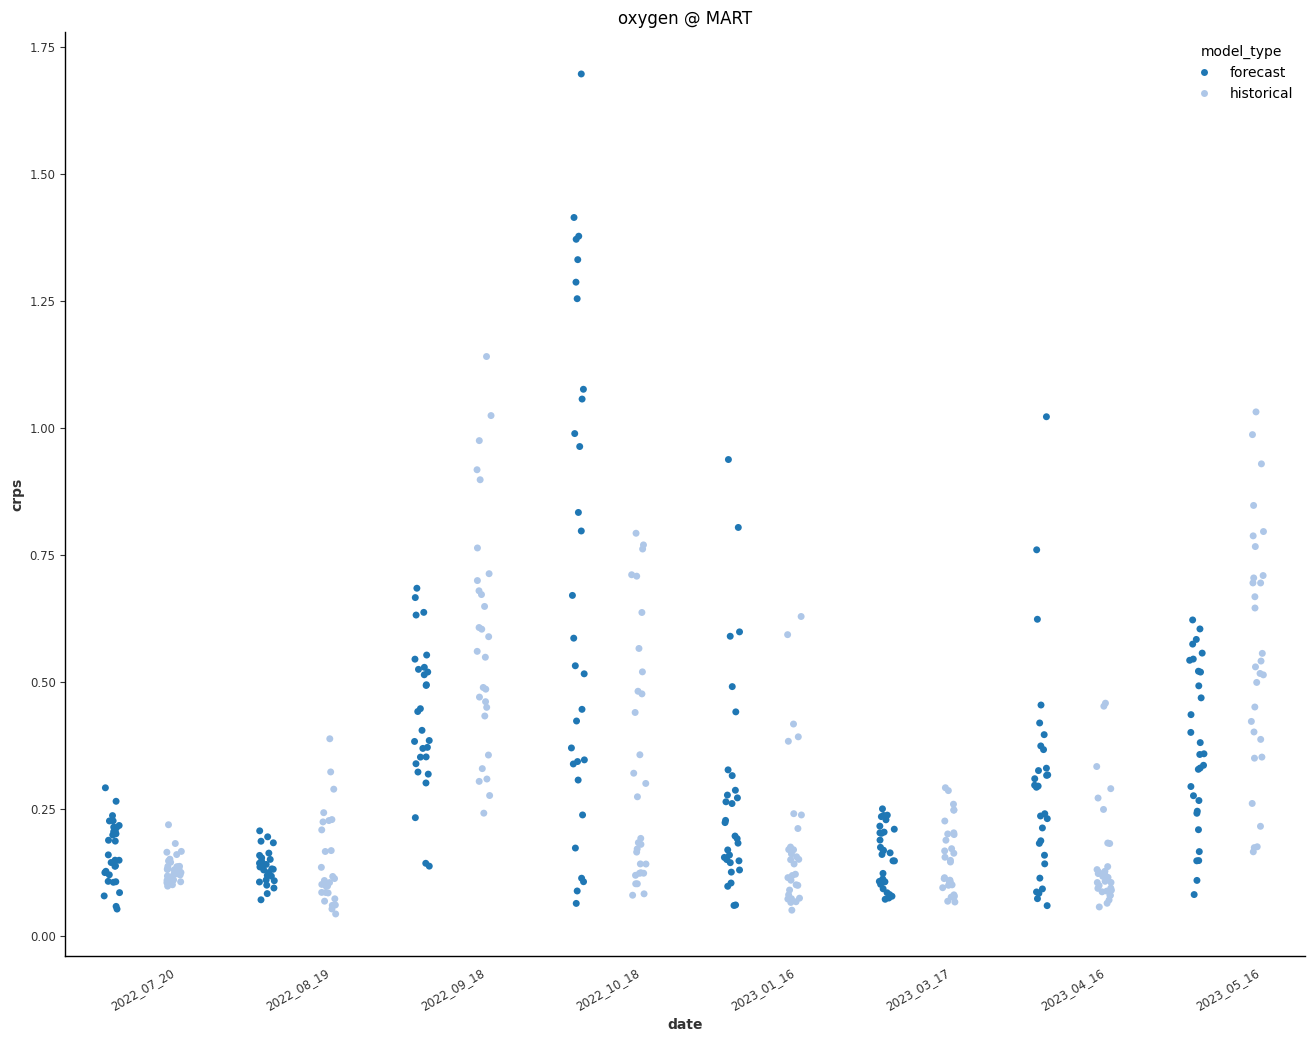

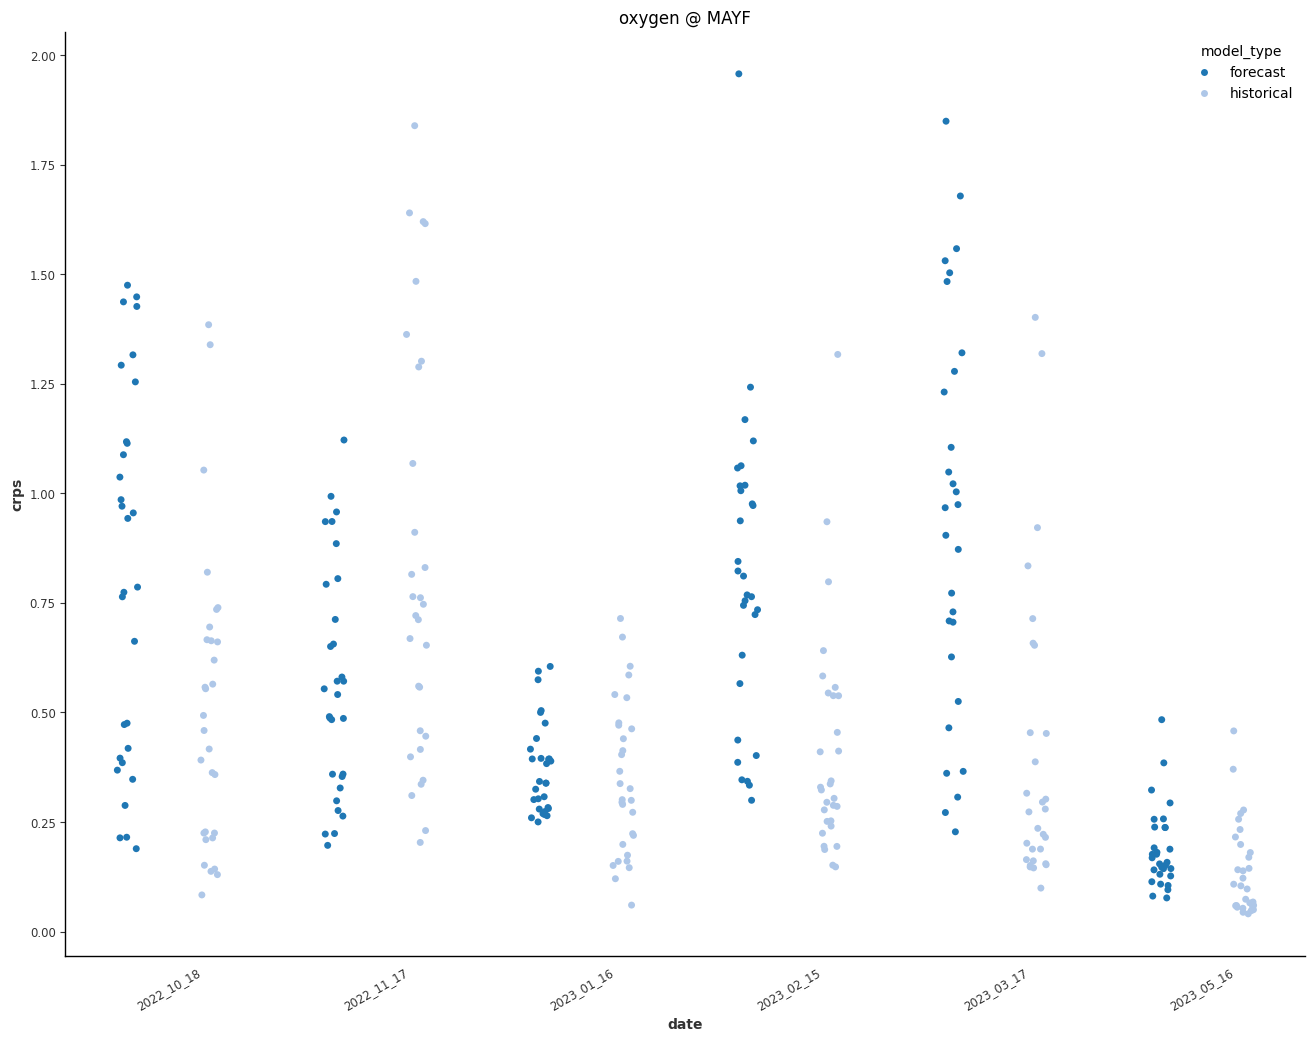

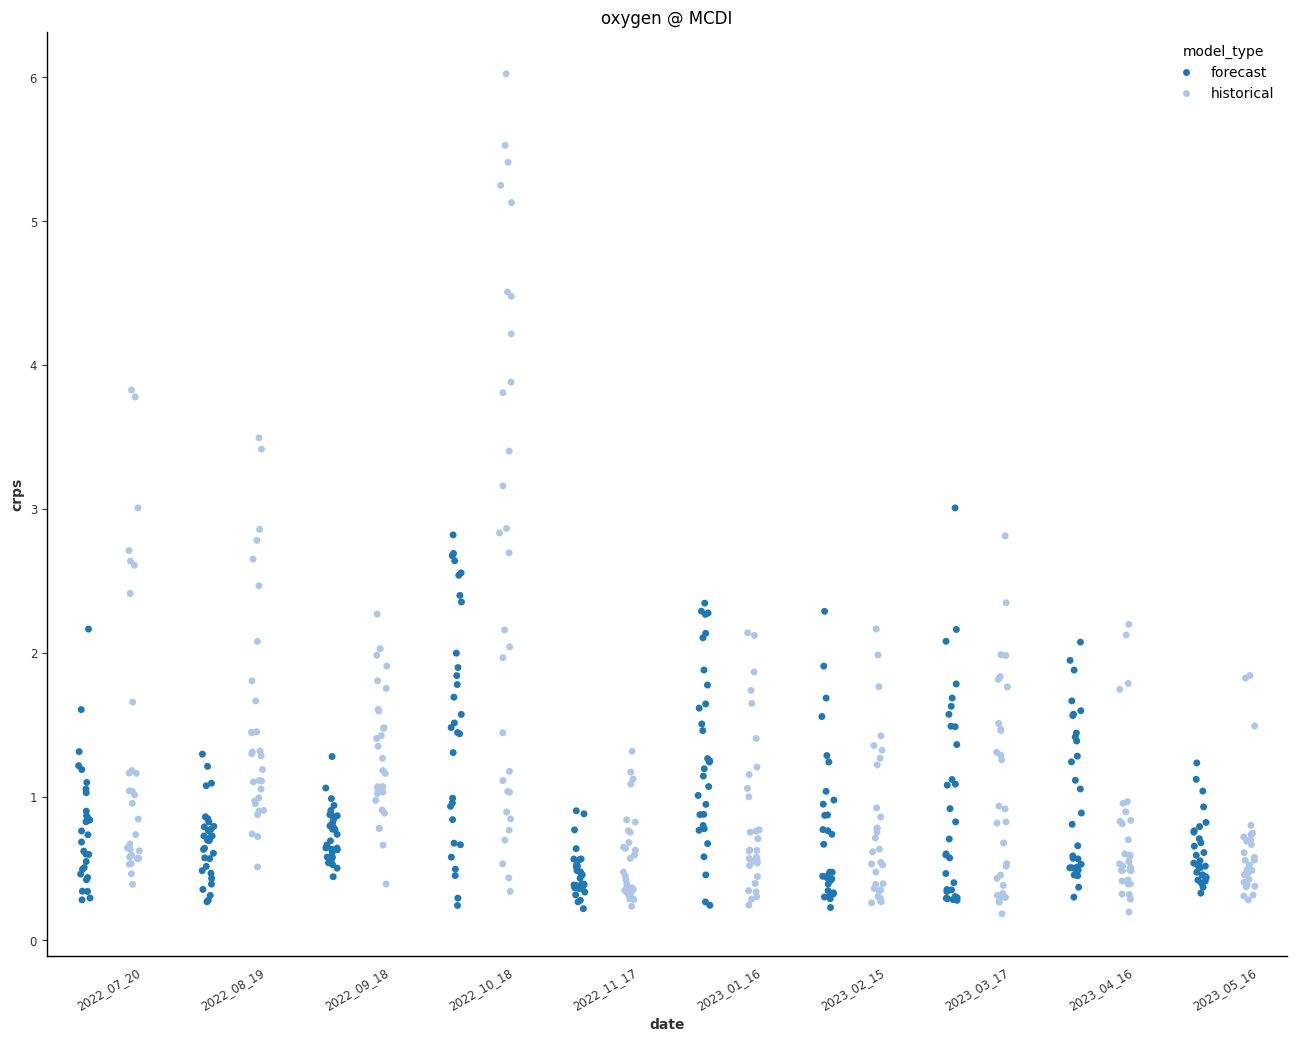

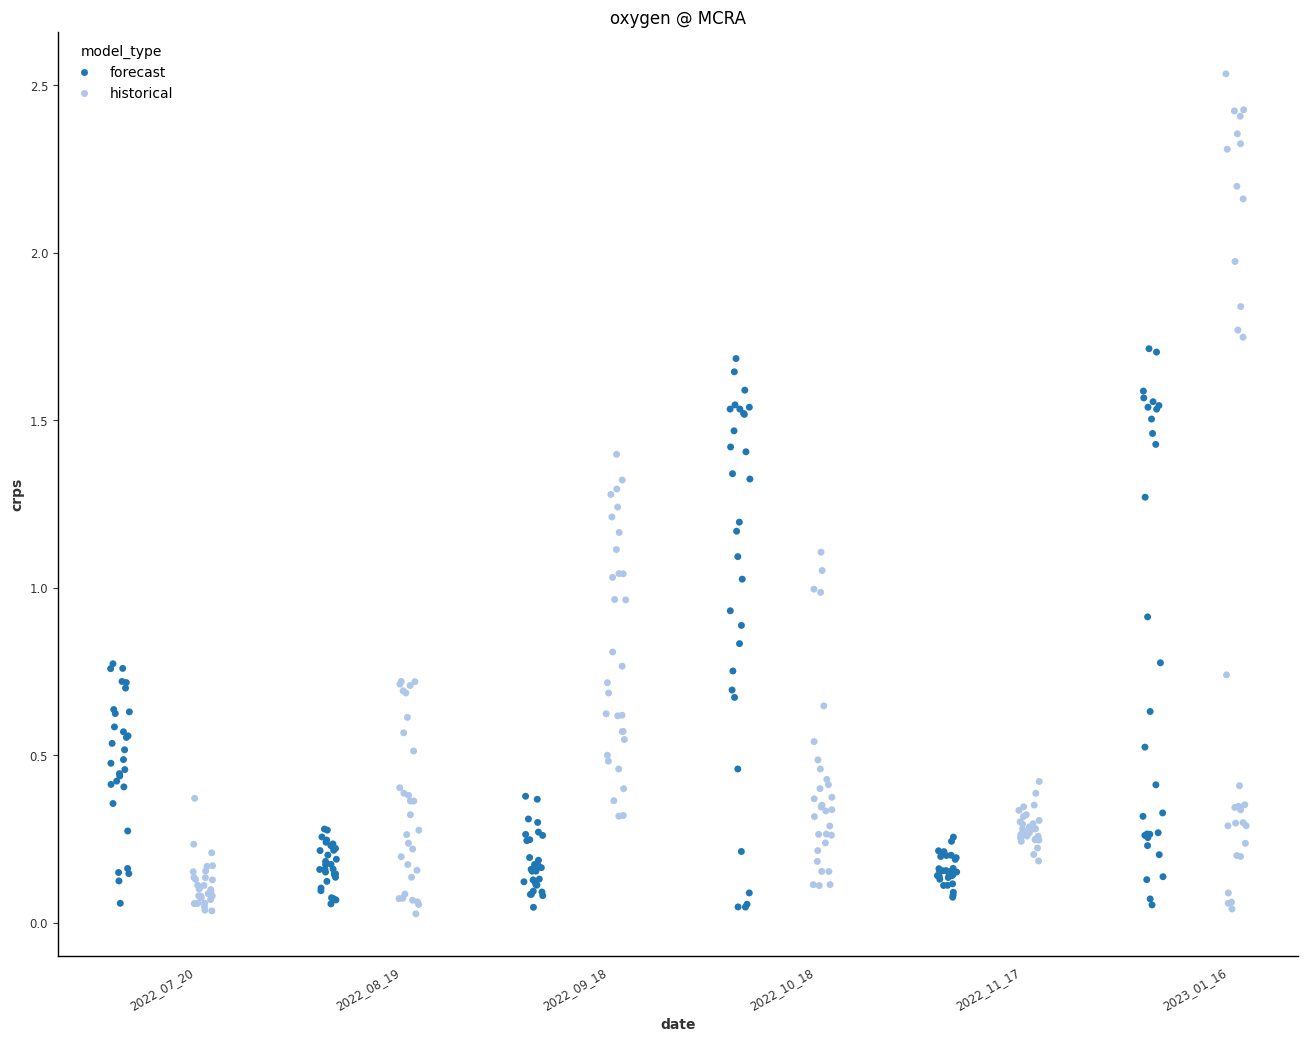

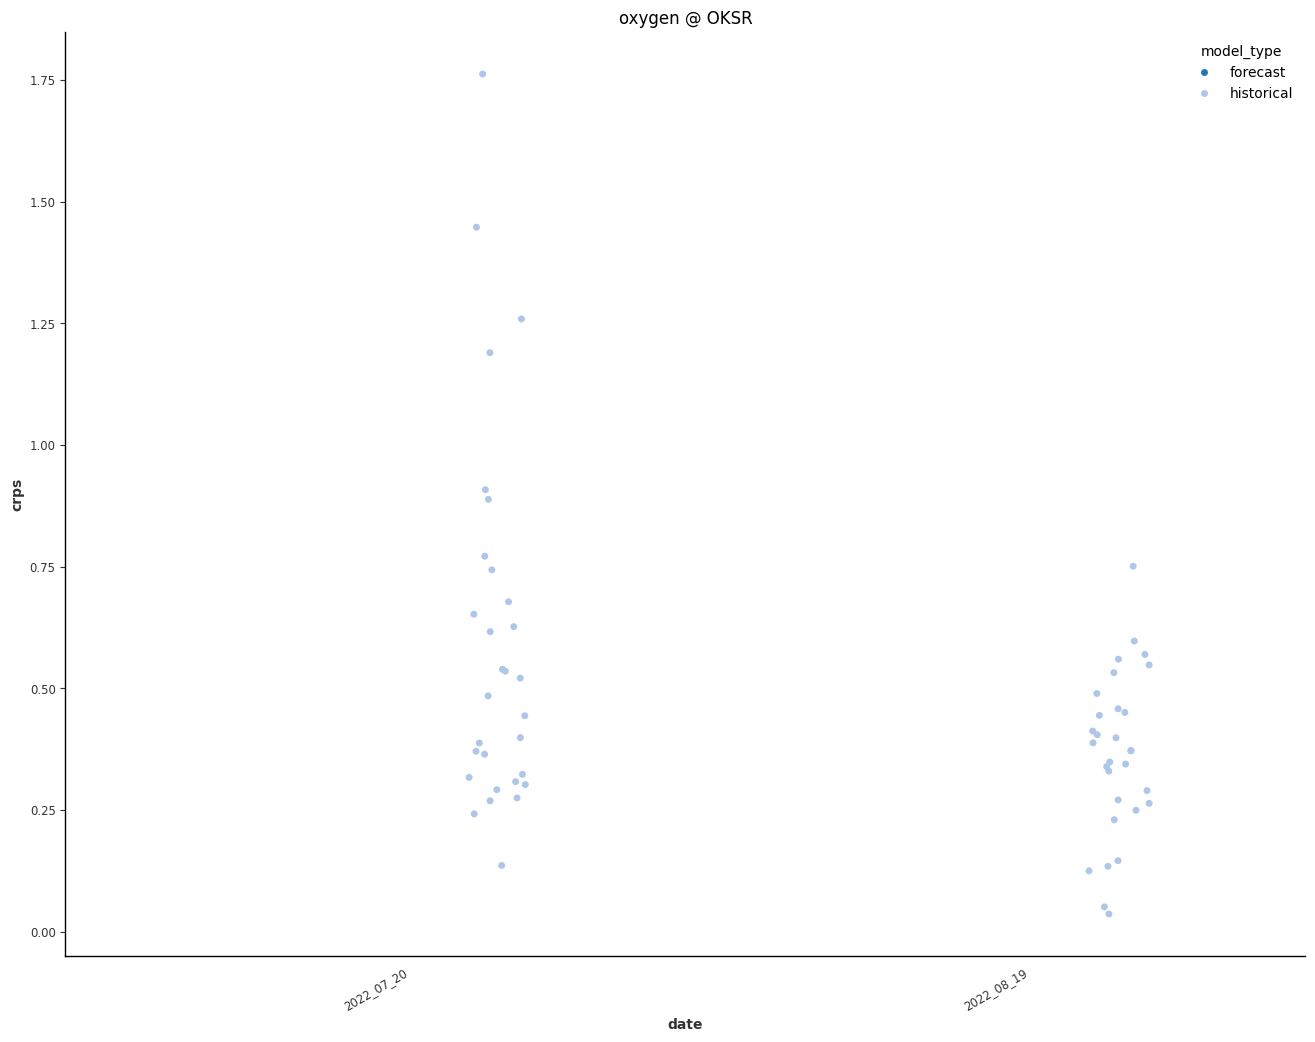

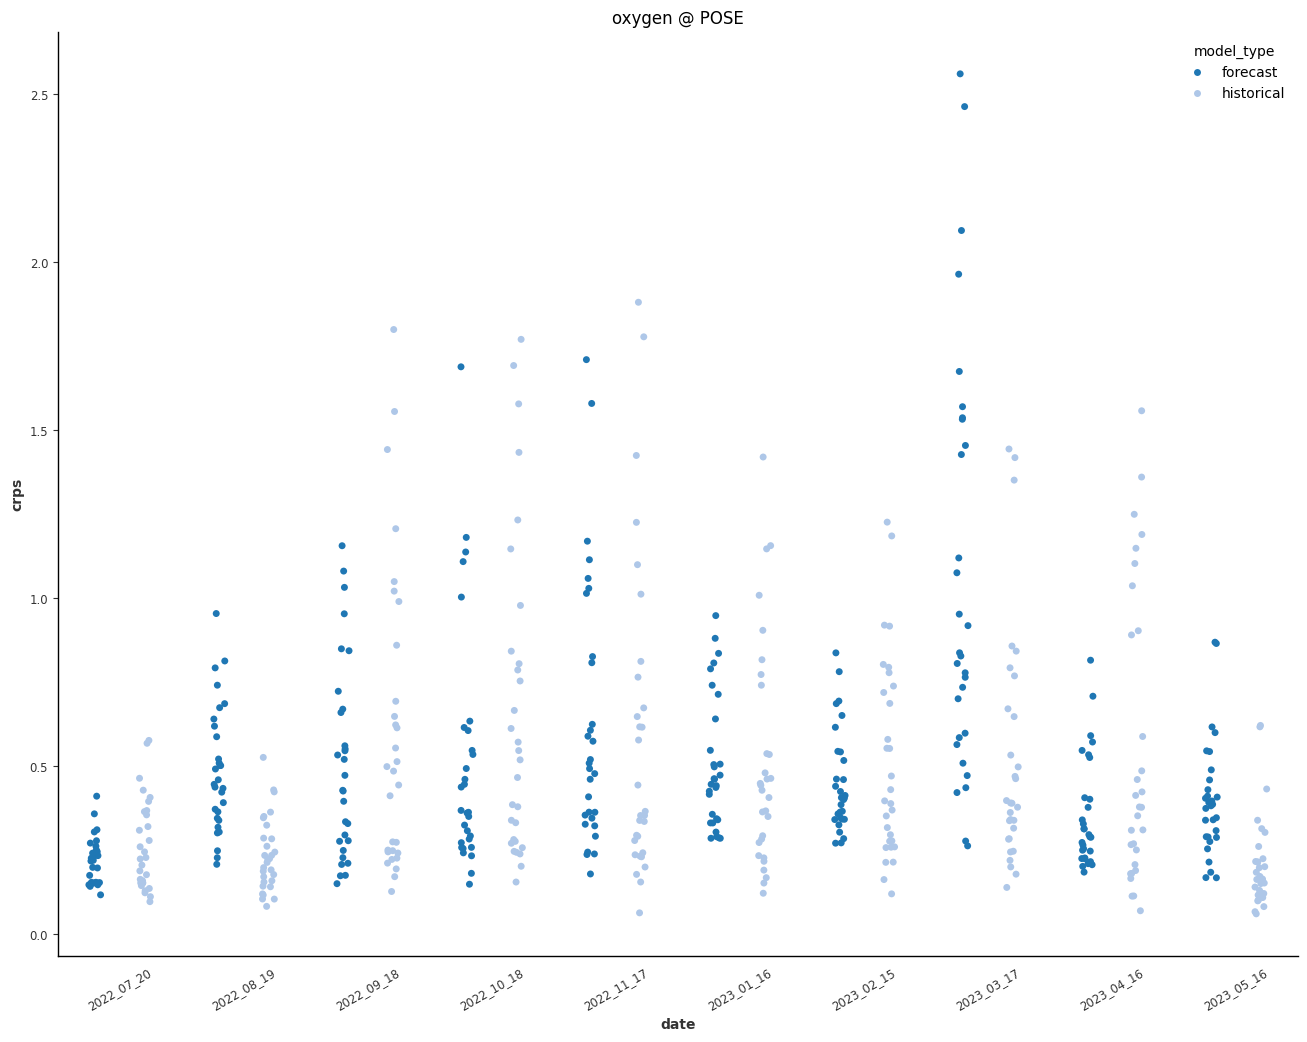

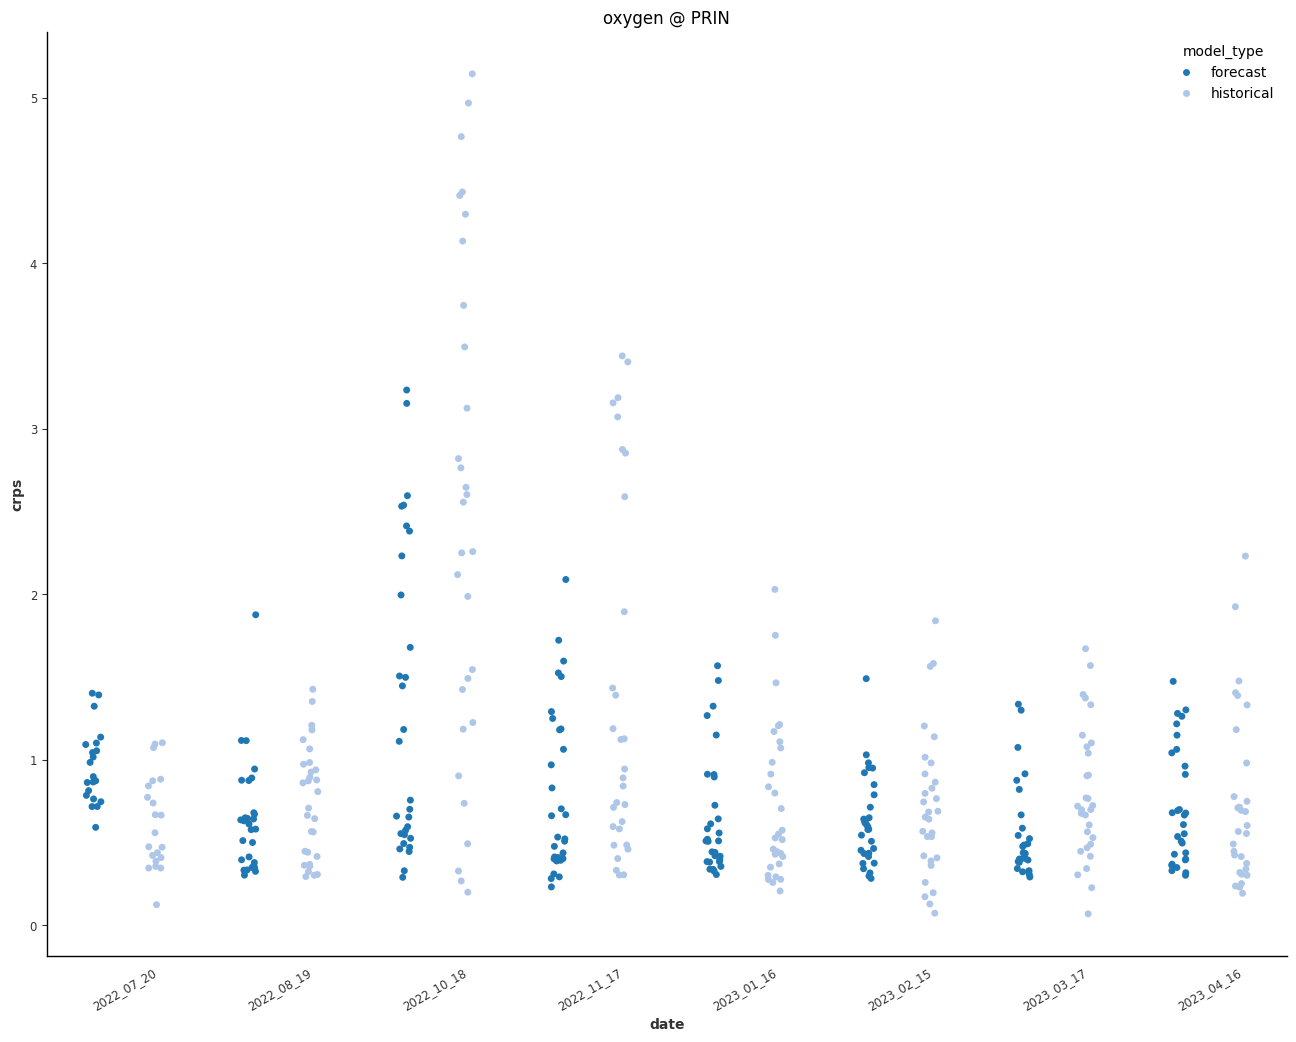

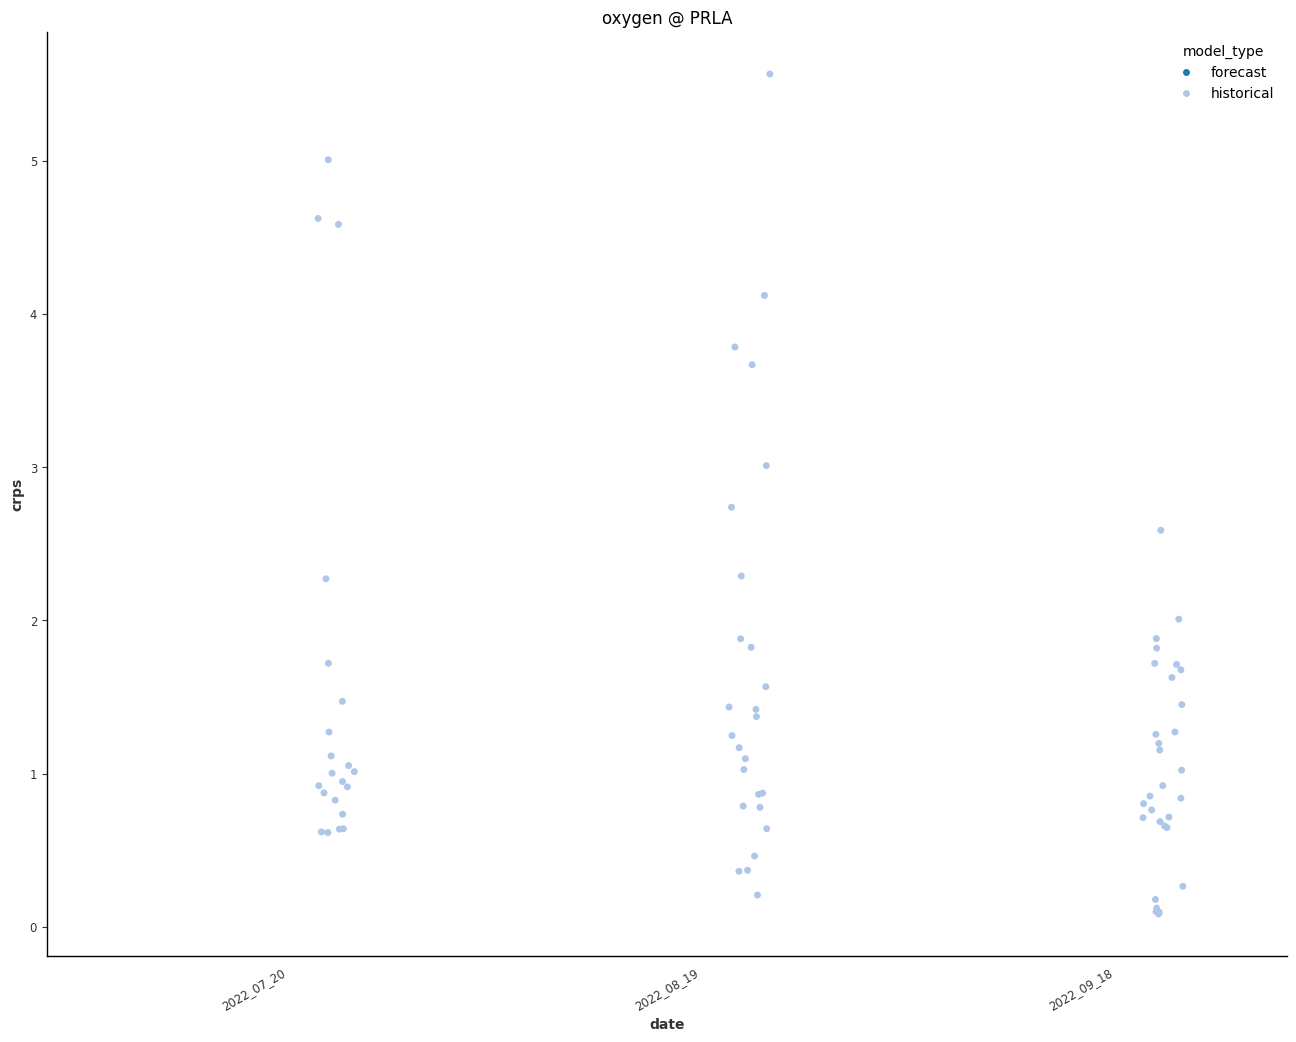

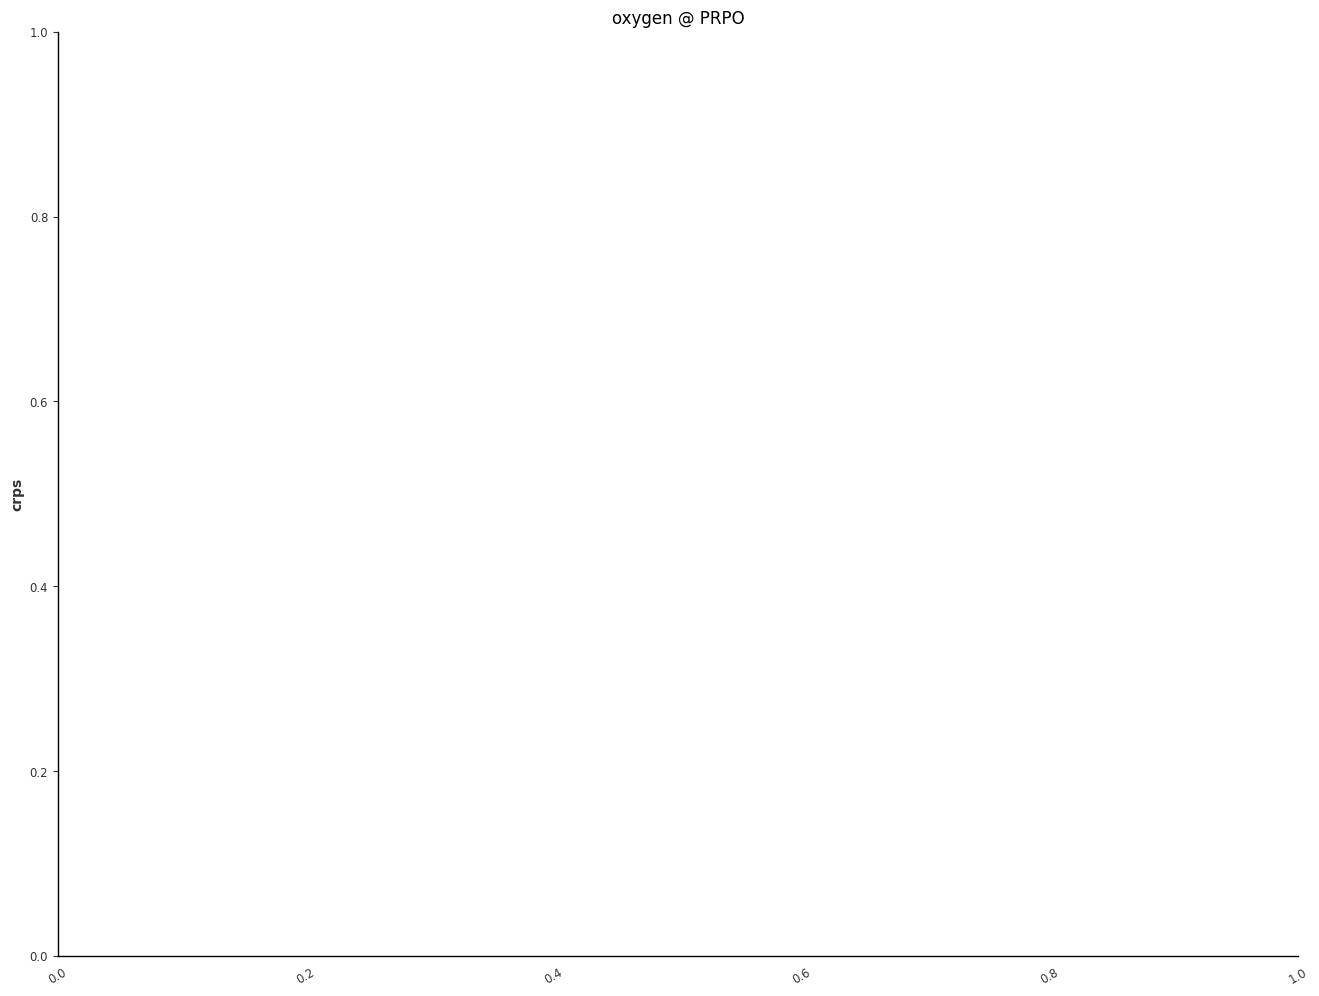

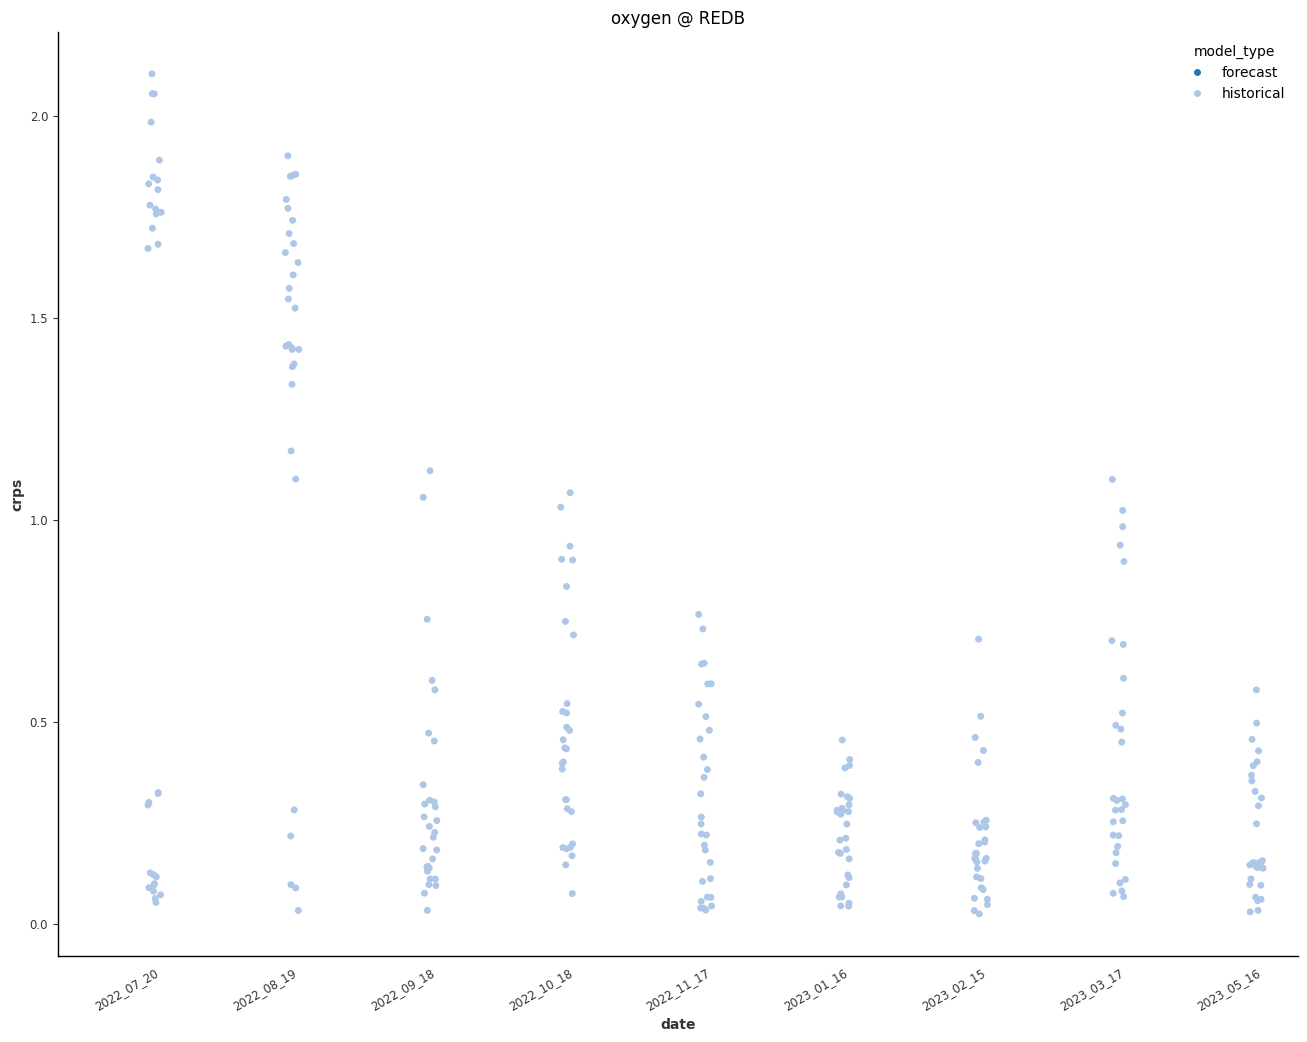

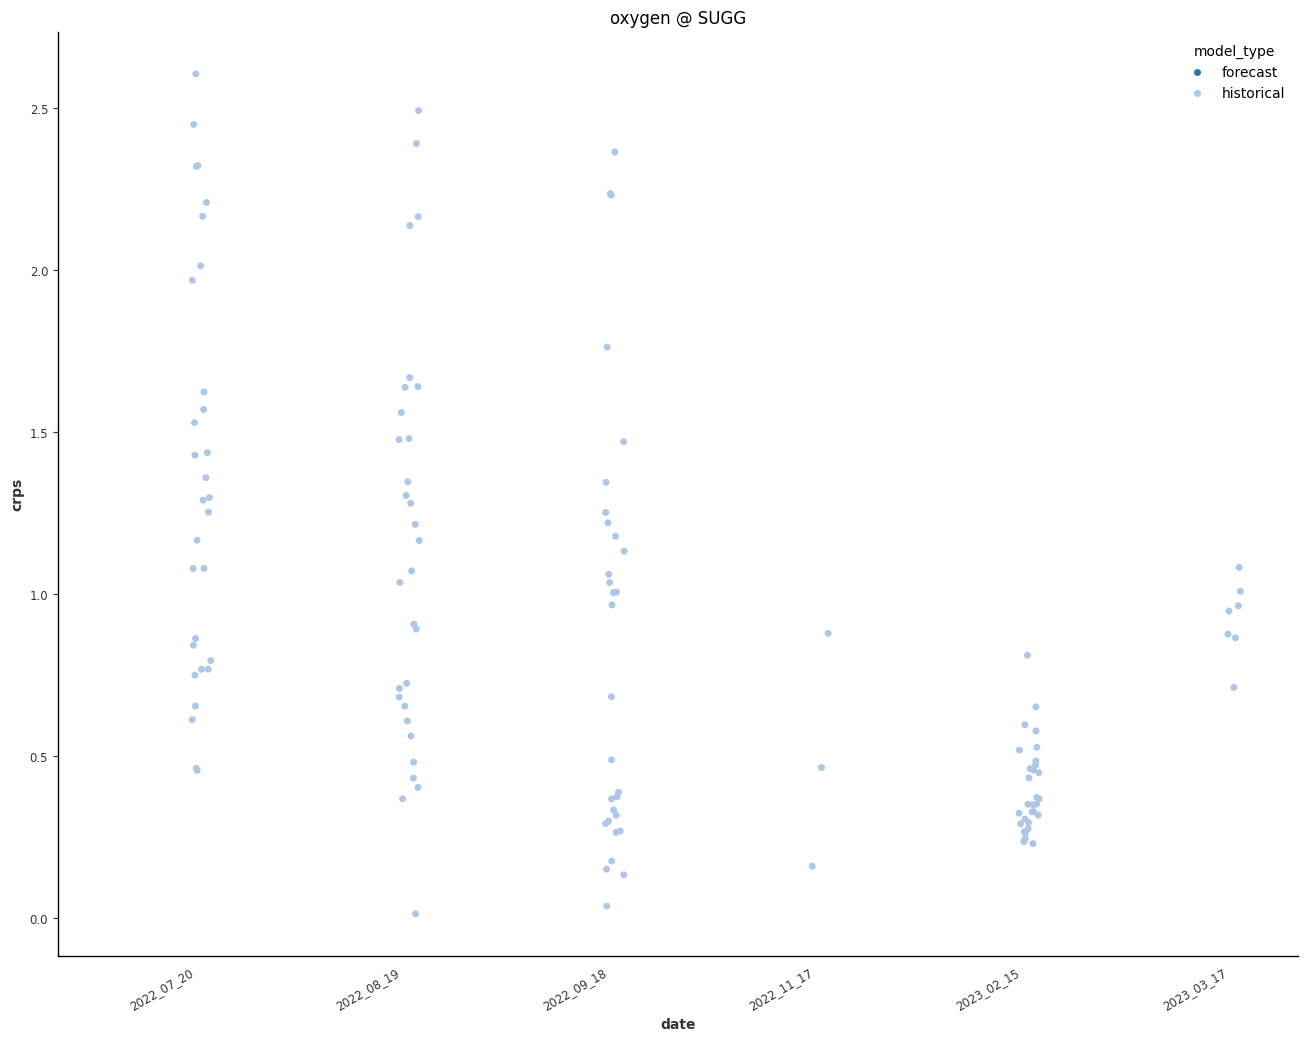

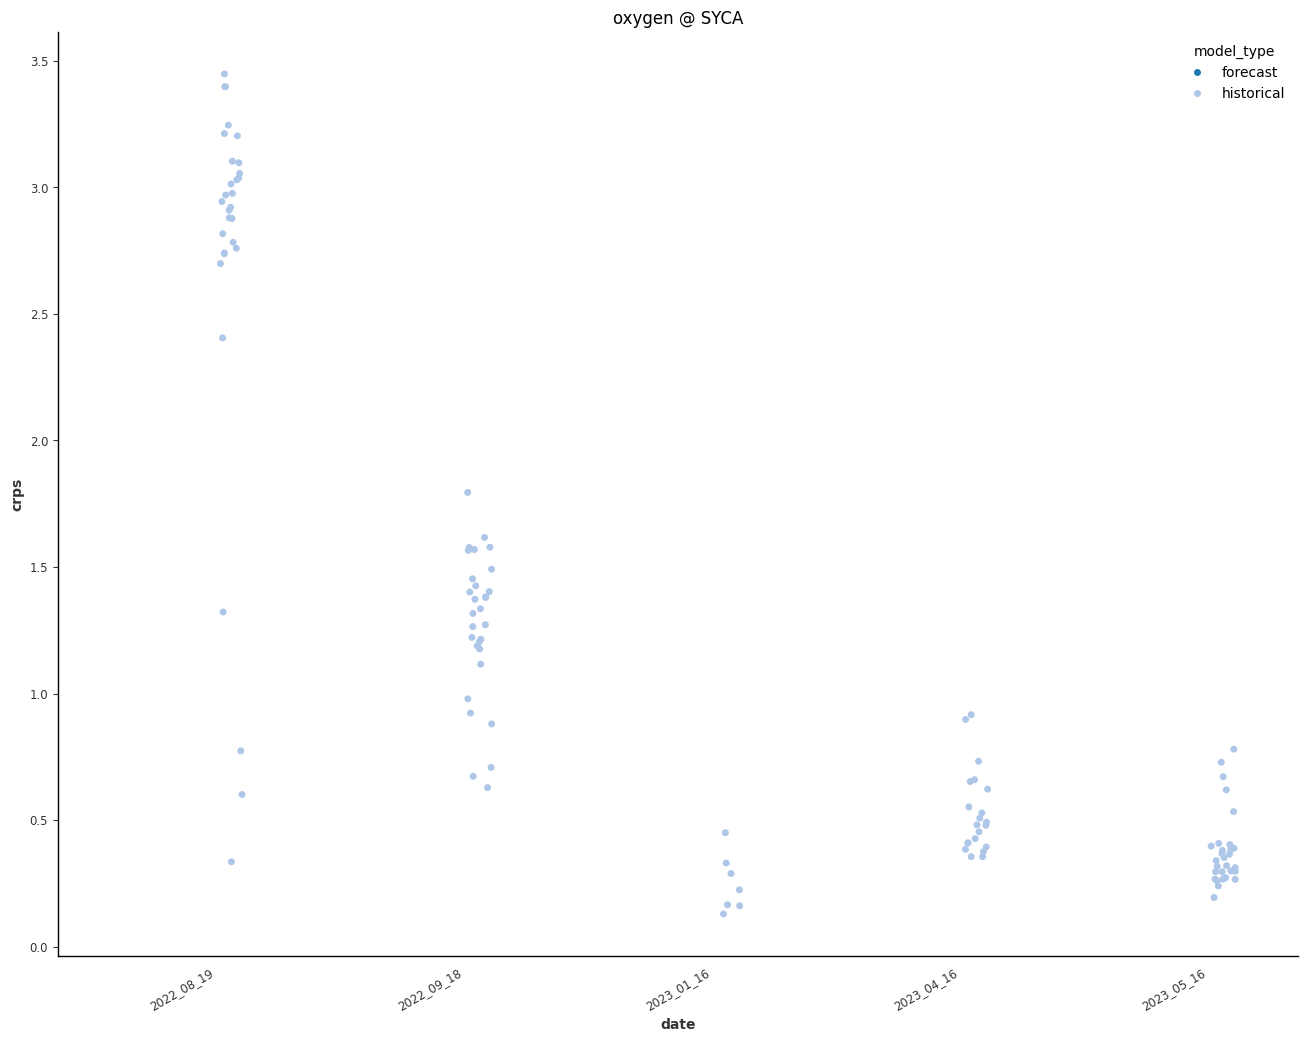

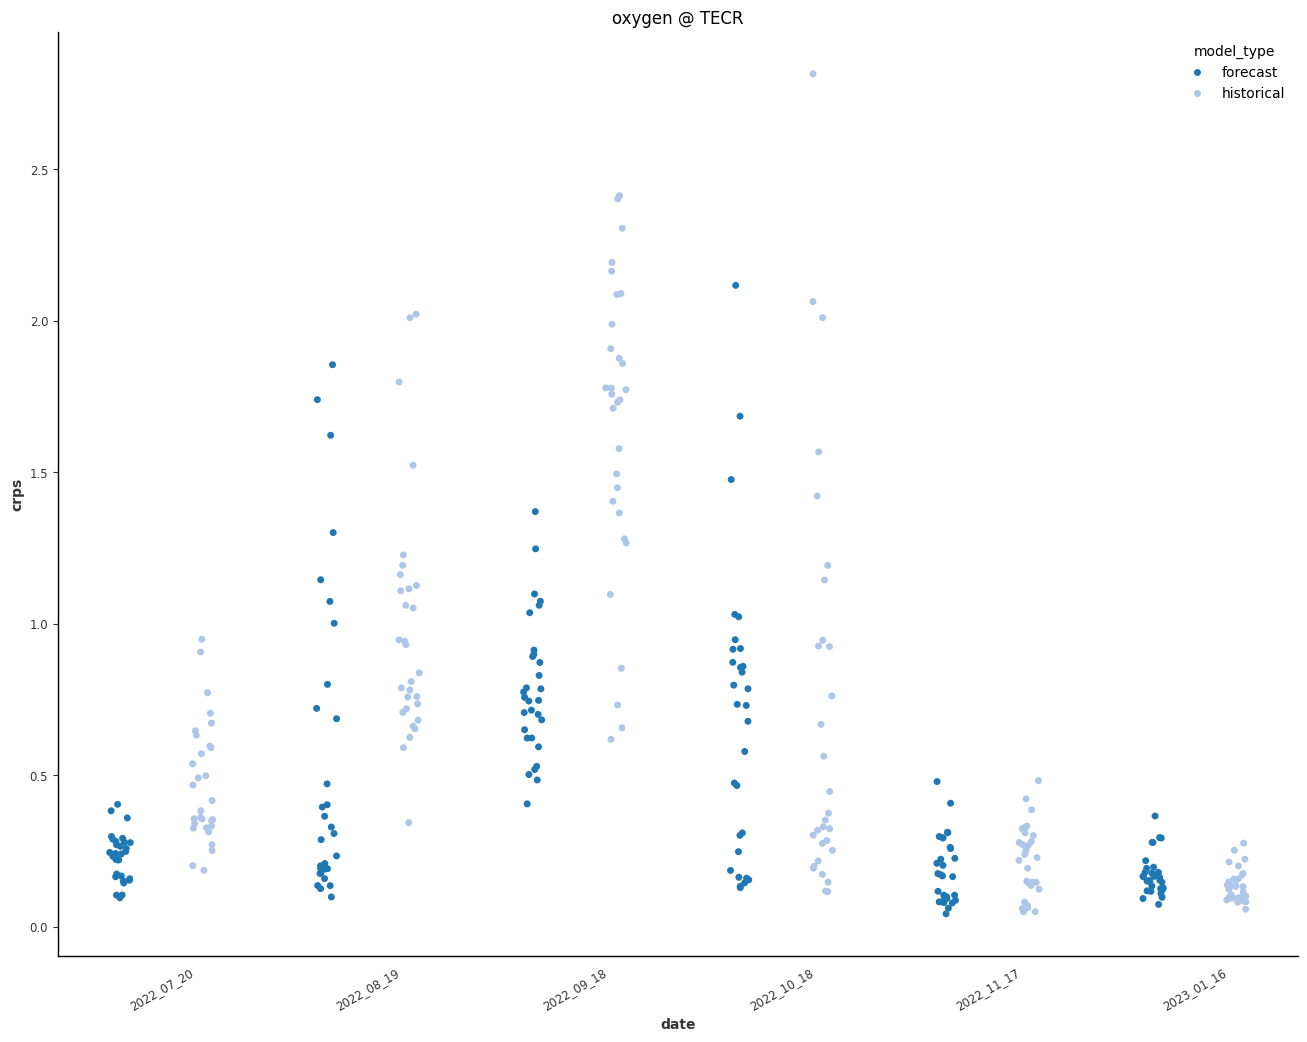

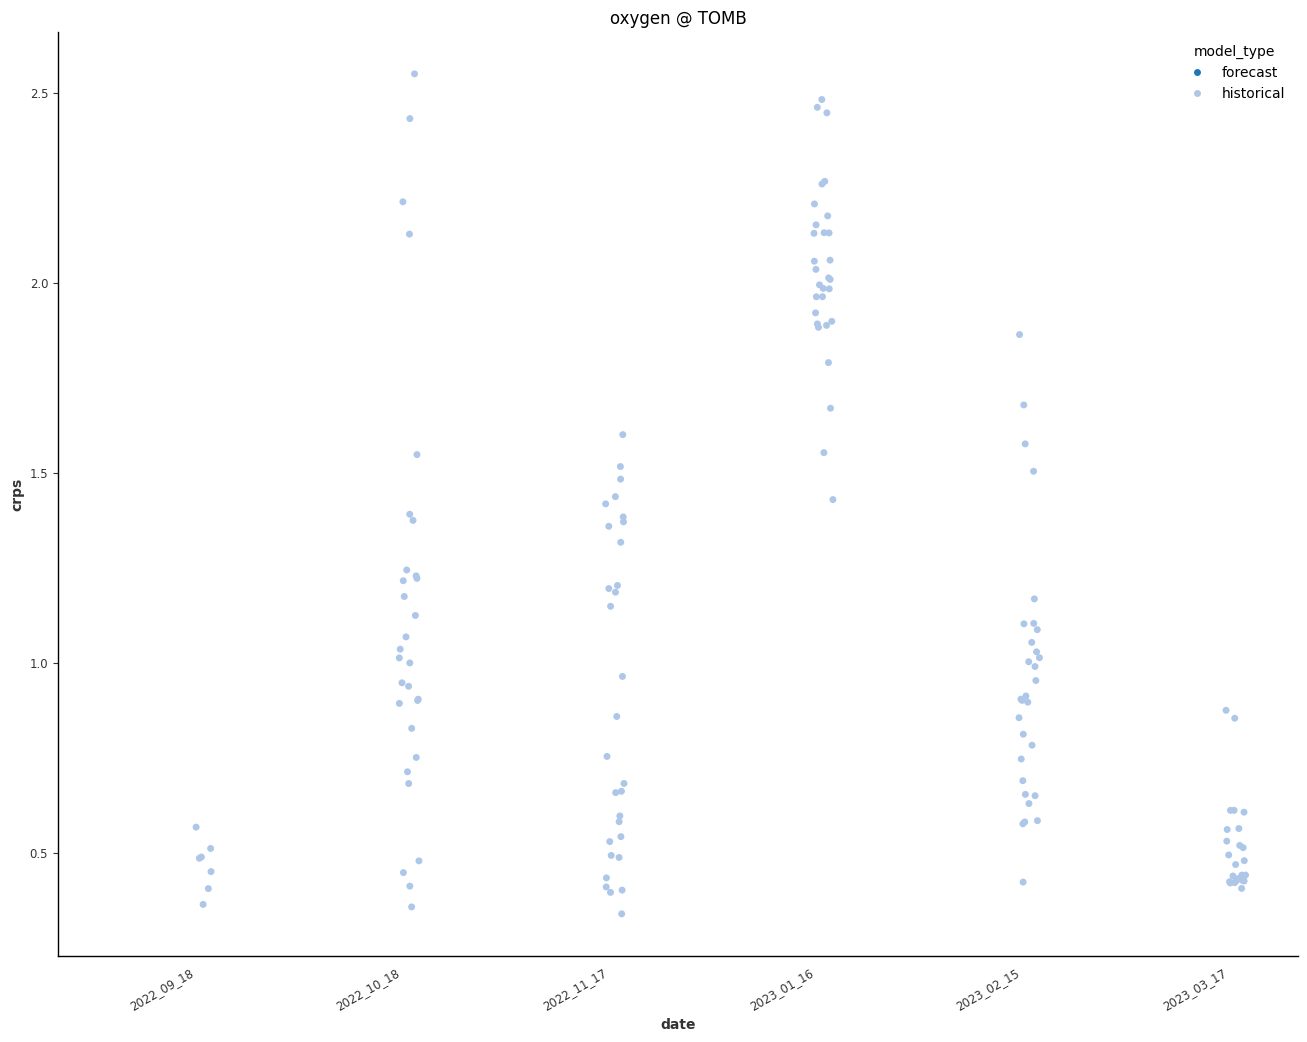

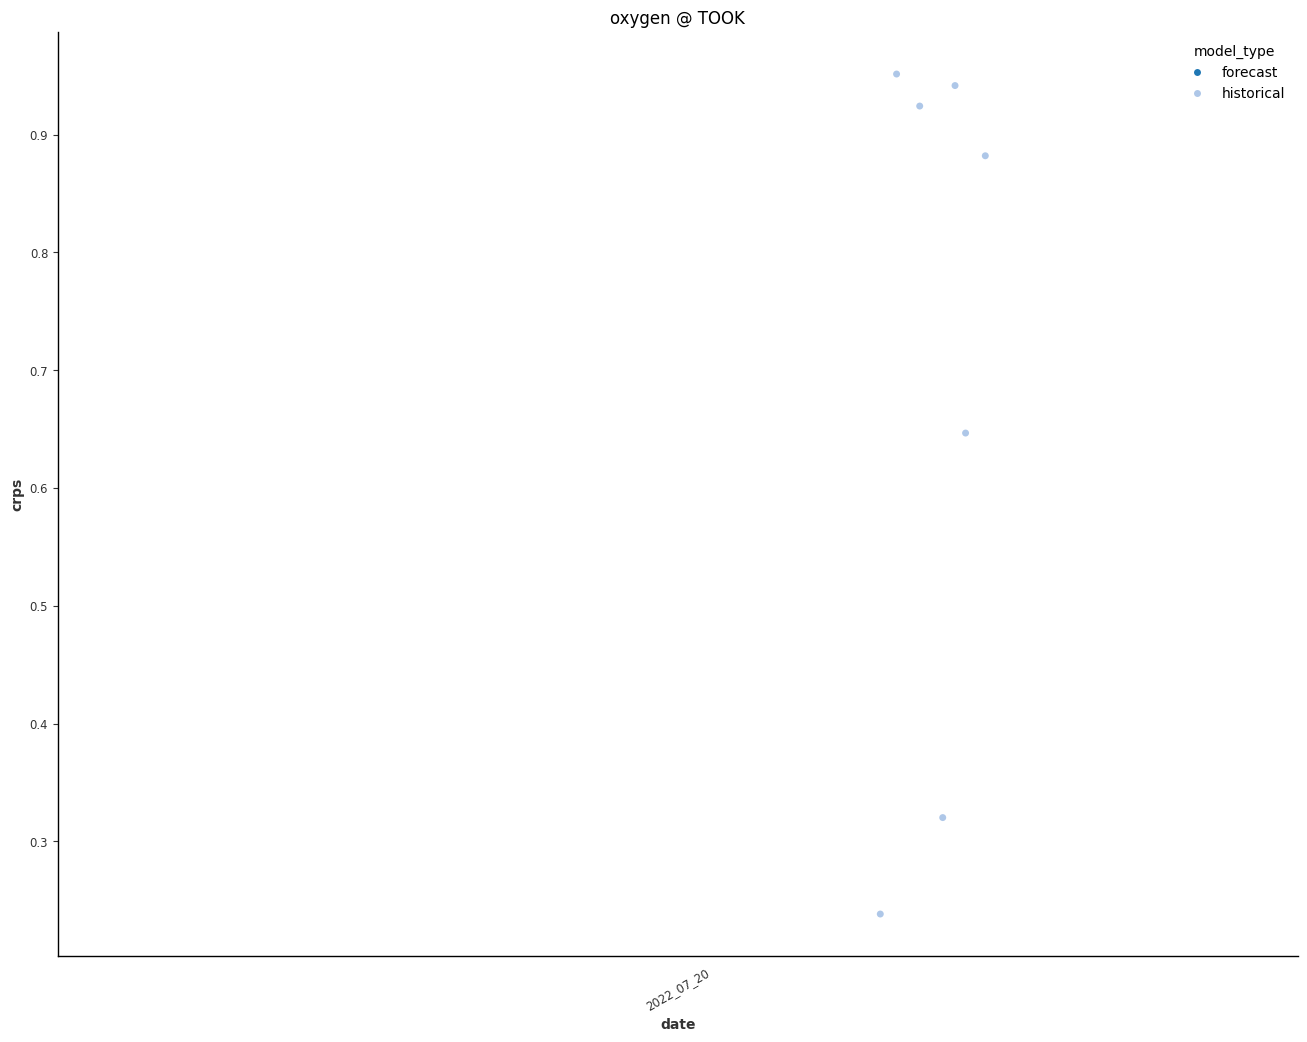

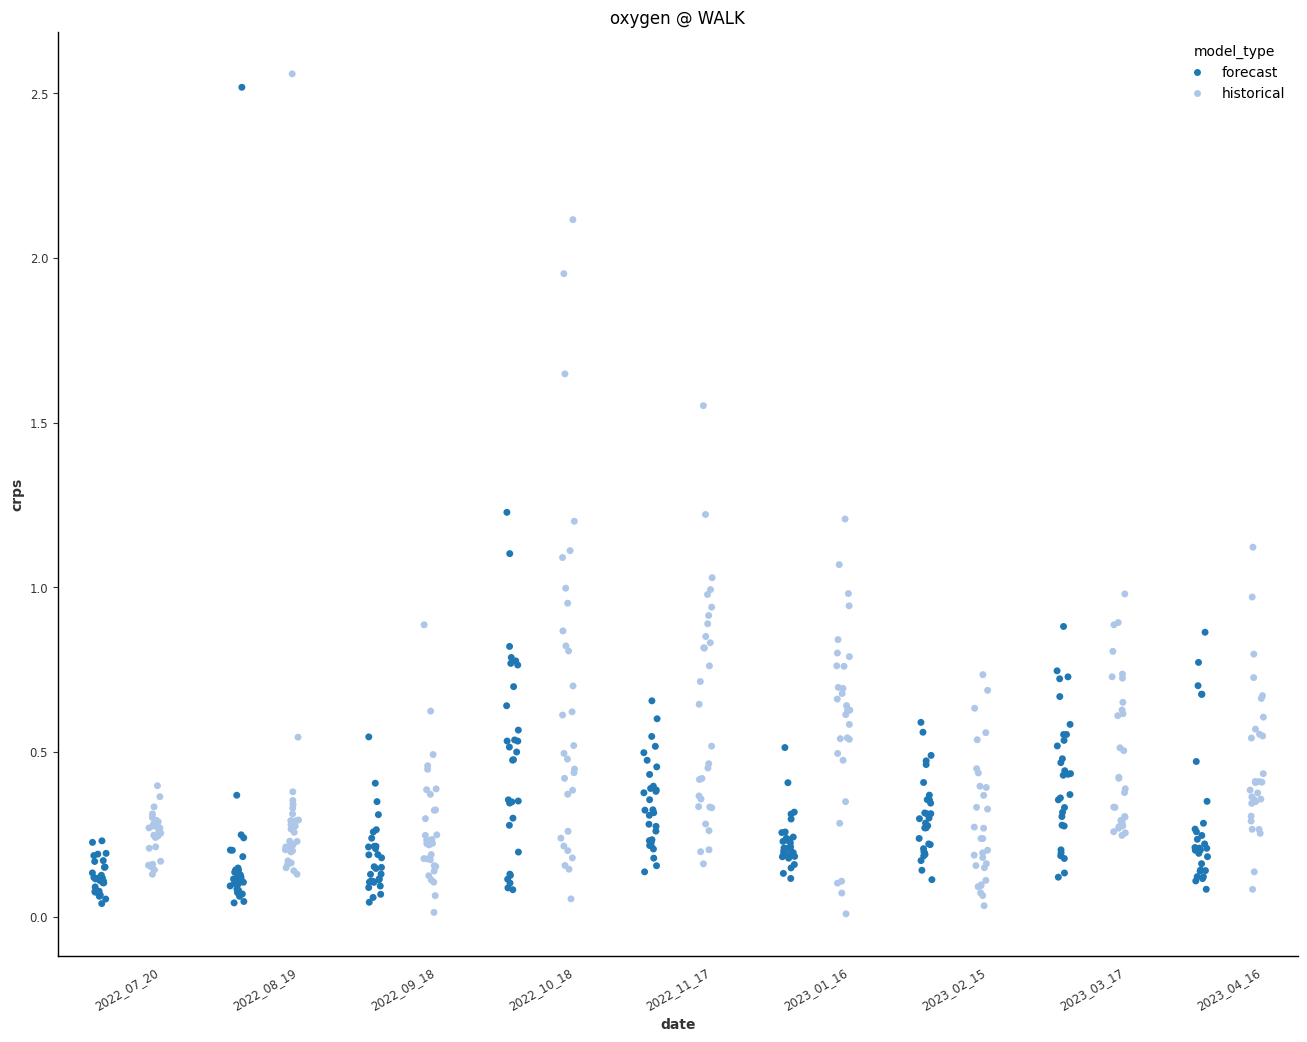

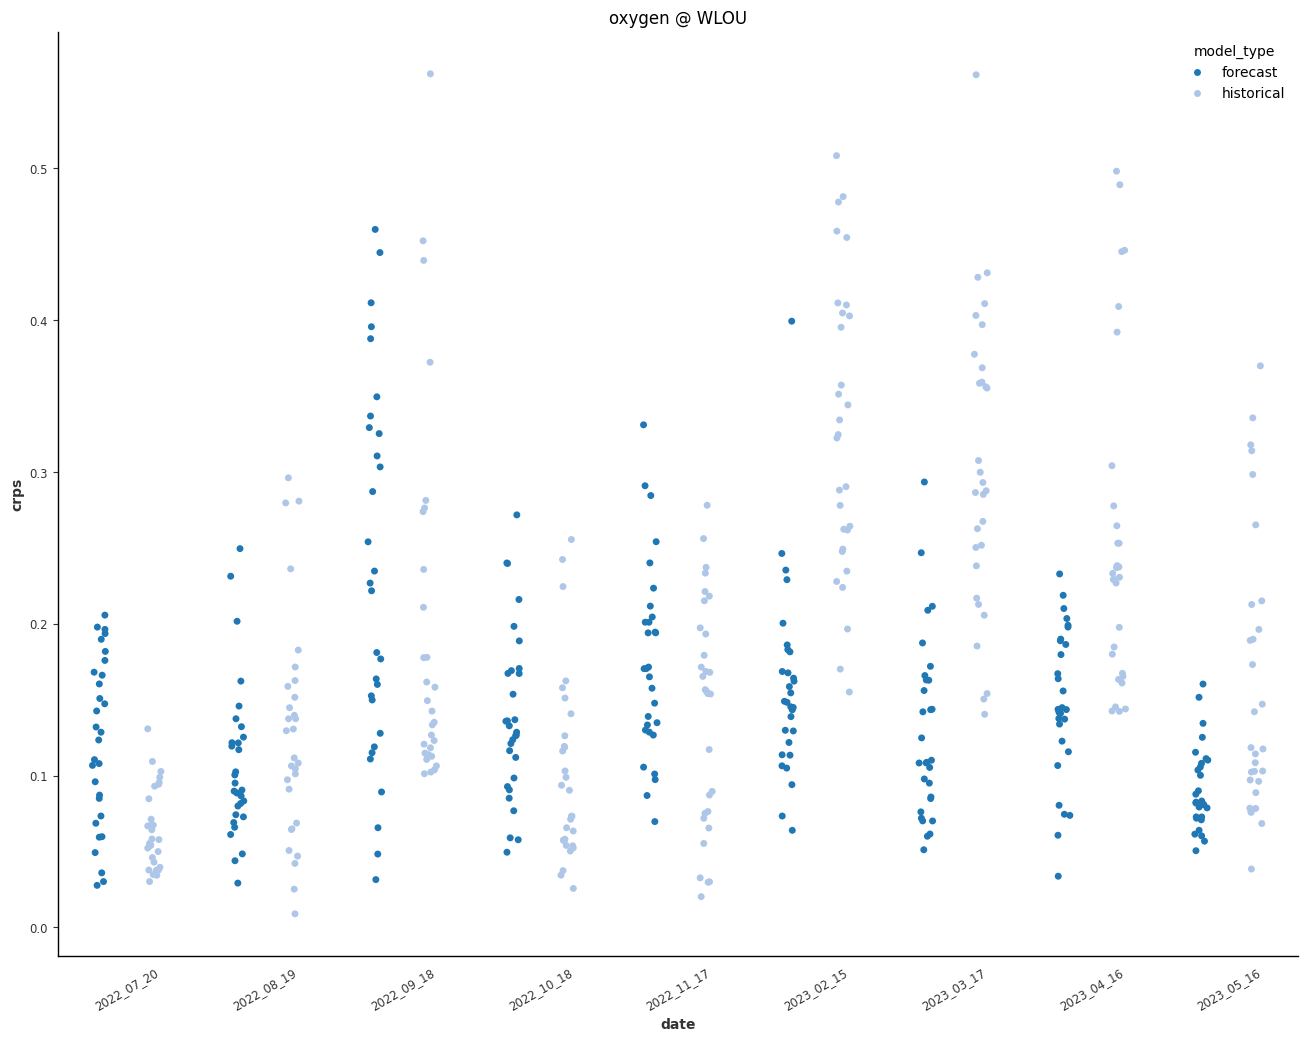

In [67]:
for site in targets.site_id.unique():
    plot_crps_bydate(f'forecasts/{site}/oxygen/BlockRNN_default/forecast*', targets, site, 'oxygen')

ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.
ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.
ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with miss

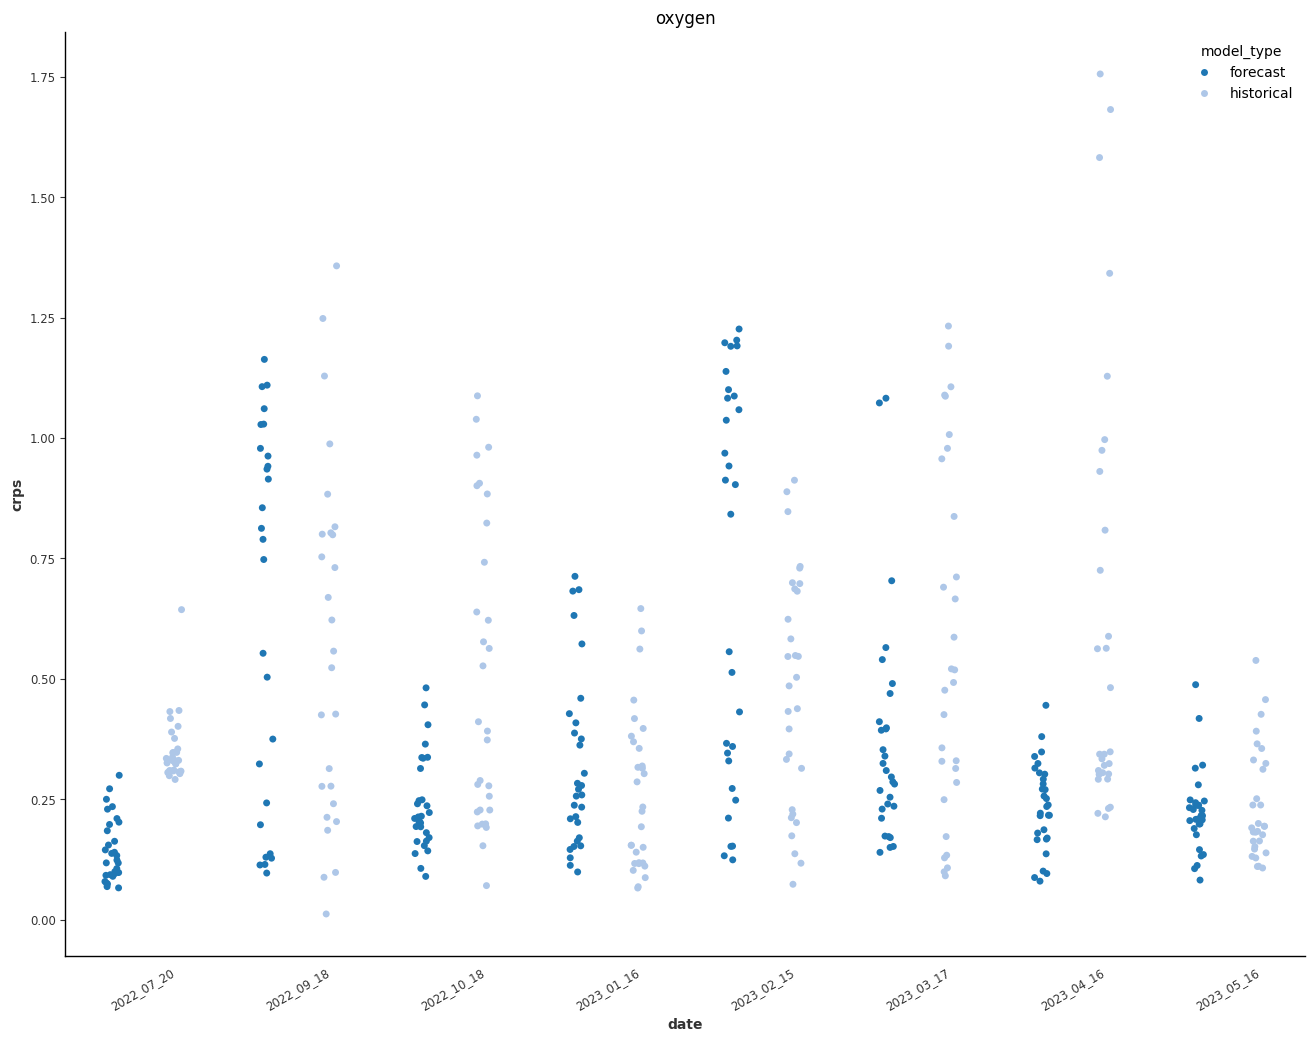

In [44]:
plot_crps_bydate('test_20*', targets, 'FLNT', 'oxygen')

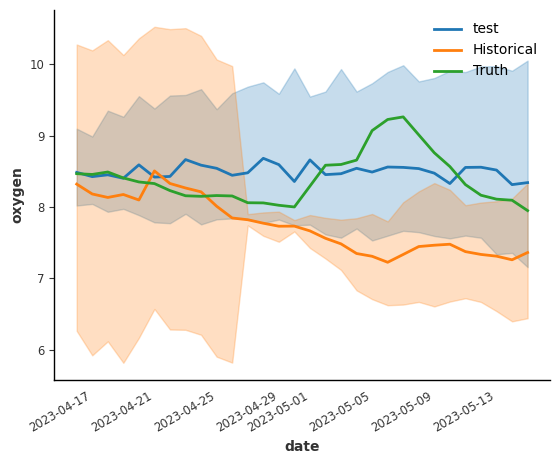

In [57]:
plot_forecasts(['test'], '2023_04_16', targets, 'FLNT', 'oxygen')

ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.
ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.
ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with miss

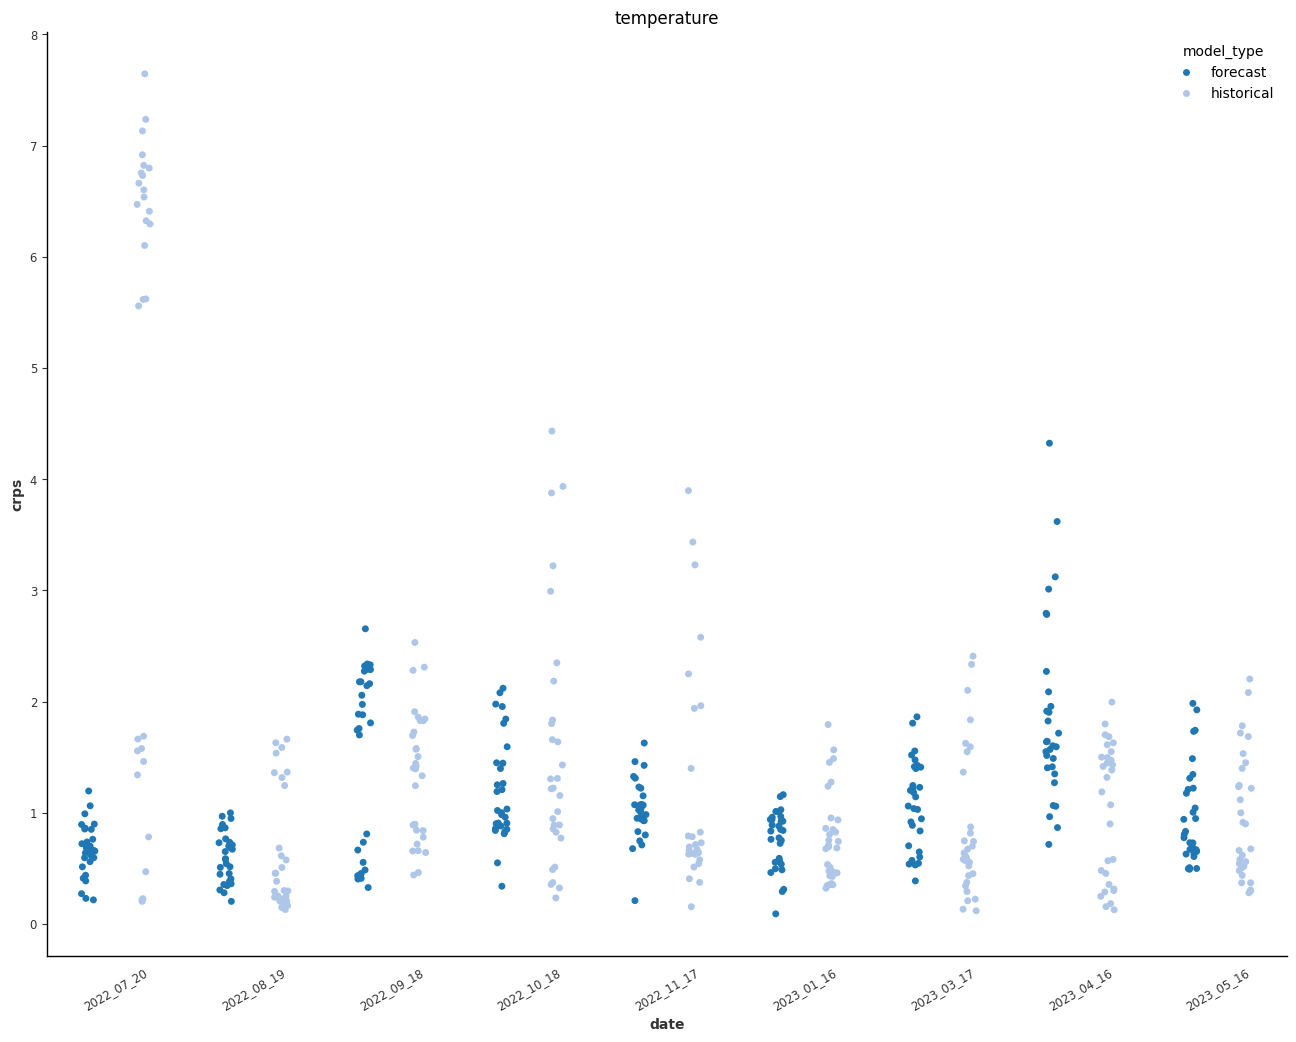

In [52]:
plot_crps_bydate('test_temperature*', targets, 'FLNT', 'temperature')

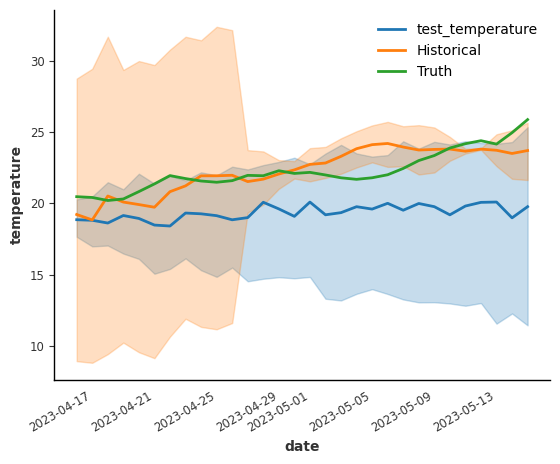

In [56]:
plot_forecasts(['test_temperature'], '2023_04_16', targets, 'FLNT', 'temperature')

ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.
ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.
ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with miss

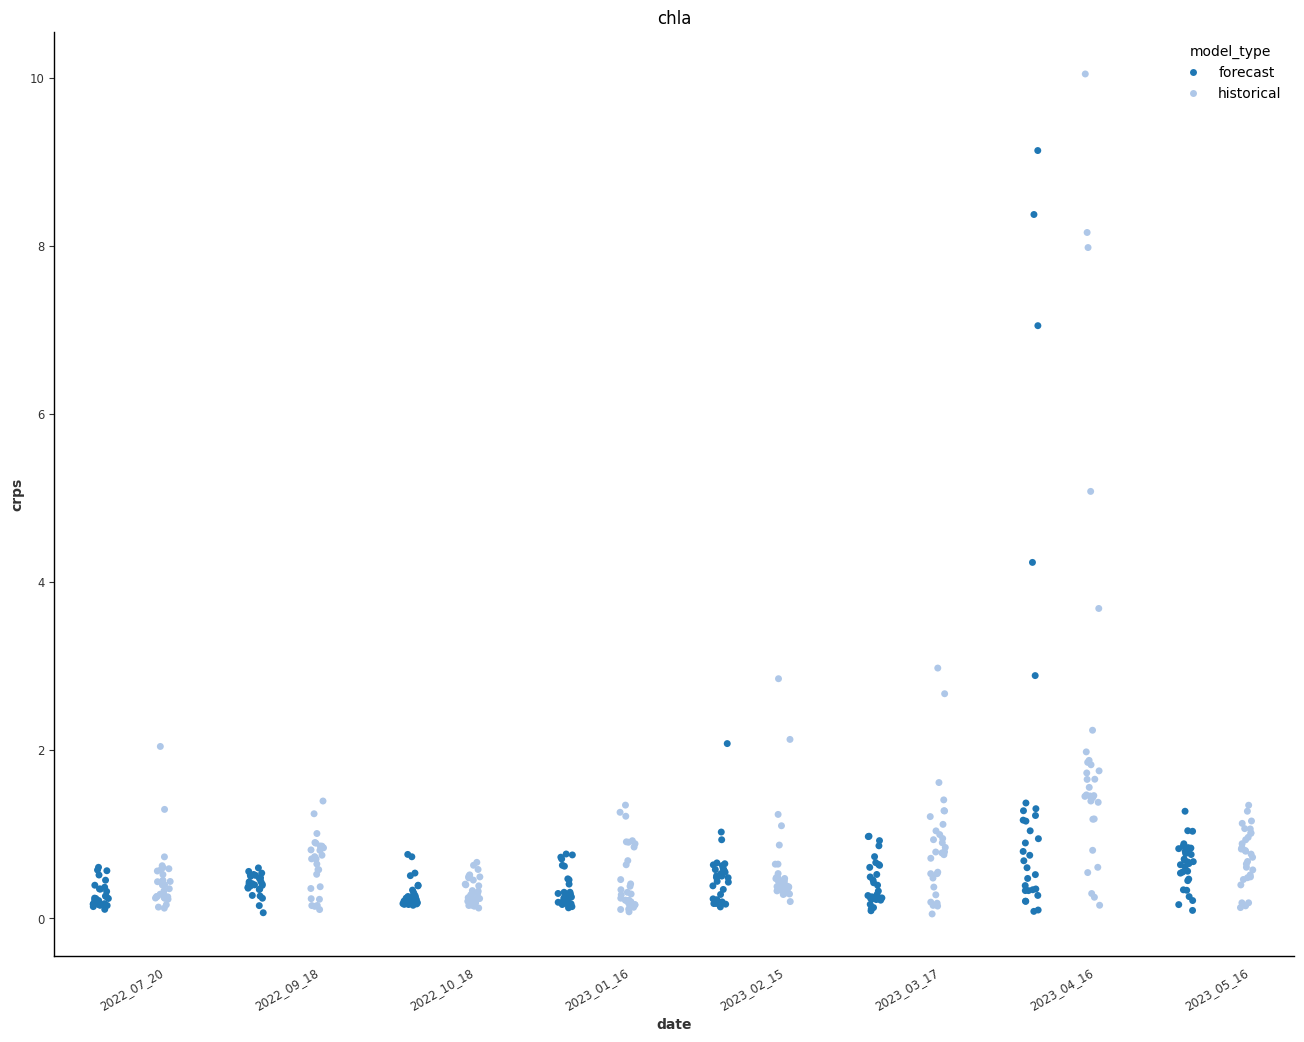

In [53]:
plot_crps_bydate('test_chla*', targets, 'FLNT', 'chla')

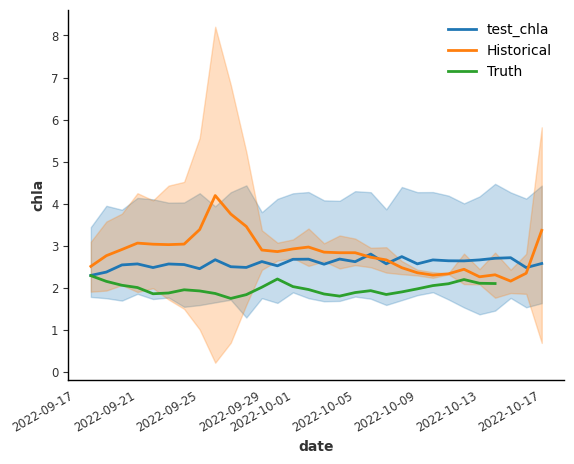

In [54]:
plot_forecasts(['test_chla'], '2022_09_18', targets, 'FLNT', 'chla')

In [66]:
import glob
def plot_crps_bydate(prefix, targets_df, site_id, target_variable, suffix="", plot_name=None):

    plt.figure(figsize=(16, 12))
    score_dict = {}

    csv_list = sorted(glob.glob(prefix))
    
    for csv in csv_list:
        score_dict = modify_score_dict(
            csv, 
            targets_df, 
            target_variable, 
            site_id, 
            suffix, 
            score_dict
        )

    score_df = pd.DataFrame([(site_id, data_dict['crps_forecast'][i], data_dict['crps_historical'][i]) \
                                 for site_id, data_dict in score_dict.items() \
                                 for i in range(len(data_dict['crps_forecast']))],
                            columns=["date", 'forecast', 'historical'])
    score_df = pd.melt(score_df, id_vars=["date"], var_name="model_type", value_name="crps")

    # Now creating the plot
    p = sns.stripplot(score_df, x="date", y="crps", hue="model_type", dodge=True, palette="tab20")

    # plot the mean line
    sns.boxplot(showmeans=False,
                meanline=False,
                meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': True, 'lw':1.75},
                whiskerprops={'visible': False},
                zorder=10,
                data=score_dict,
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=p)
    plt.grid(False)
    plt.ylabel("crps")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.title(f'{target_variable} @ {site_id}')
    
    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

In [33]:
def modify_score_dict(csv, targets_df, target_variable, site_id, suffix, score_dict, score_rmse=False):
    import pdb; pdb.set_trace()
    try:
        forecast_df = pd.read_csv(csv)
    except:
        return score_dict
    forecast_df["datetime"] = pd.to_datetime(forecast_df["datetime"])
    times = pd.DatetimeIndex(forecast_df["datetime"])
    forecast_df = forecast_df.set_index("datetime")

    # Getting the validation set from targets
    forecast_horizon = len(forecast_df)
    validation_series = get_validation_series(
        targets_df, 
        site_id, 
        target_variable, 
        times[0], 
        forecast_horizon,
    )

    # If there is no validation set at the site skip
    if len(validation_series) == 0:
        return score_dict

    try:
        filtered_model_forecast, filtered_validation_series = filter_forecast_df(
            forecast_df, 
            validation_series
        )
    except:
        return score_dict

    # Initialize in case site id is empty at the site
    time_str = times[0].strftime('%Y_%m_%d')
    if time_str not in score_dict:
        score_dict[time_str] = {}
        
    # Computing CRPS and recording
    if score_rmse:
        filtered_validation_ts = TimeSeries.from_times_and_values(
            filtered_validation_series.index, 
            filtered_validation_series.values, 
            fill_missing_dates=False
        )
        rmse_score = rmse(filtered_validation_ts, filtered_model_forecast)
        score_dict[time_str]["rmse_forecast"] = rmse_score
    else:
        crps_scores = crps(filtered_model_forecast, filtered_validation_series)
        score_dict[time_str]["crps_forecast"] = crps_scores.pd_dataframe().values[:, 0]
        
    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(
        targets=targets_df,
        site_id=site_id,
        target_variable=target_variable,
        output_csv_name=None,
        validation_split_date=str(times[0])[:10],
        forecast_horizon=forecast_horizon,
    )
    # Computing CRPS of historical forecast and plotting
    # If issue making historical forecasts, then we'll skip.
    try:
        historical_model.make_forecasts()
    except:
        del score_dict[time_str]
        return score_dict
    historical_forecast_df = historical_model.forecast_ts.pd_dataframe(
        suppress_warnings=True
    )
    filtered_historical_forecast, filtered_validation_series = filter_forecast_df(
        historical_forecast_df, 
        validation_series
    )

    if score_rmse:
        rmse_score = rmse(filtered_validation_ts, filtered_historical_forecast)
        score_dict[time_str]["rmse_historical"] = rmse_score
    else:
        crps_scores = crps(filtered_historical_forecast, filtered_validation_series)
        score_dict[time_str]["crps_historical"] = crps_scores.pd_dataframe().values[:, 0]
    return score_dict